## Global Settings: Saving Outputs and Logs

**Why we do this:**
To maintain a reproducible record of our analysis, we configure the environment to automatically save all generated plots to a dedicated directory and log the computational steps to a text file. This ensures that we have high-quality figures for the final report and a detailed audit trail of the analysis.

**How we do this:**
We create a directory structure and modify `sc.settings`. We set `figdir` to our output folder and enable `autosave`. We also define a `logfile` to capture Scanpy's textual output (verbosity level 3 captures detailed hints and info).

**Expected Results:**
A new folder named `project_outputs/figures/` will be created. All subsequent plots generated by `sc.pl` functions will be saved there as PNGs. A file `analysis_log.txt` will be created to record processing steps.

In [268]:
import os
import scanpy as sc
import logging
import sys

output_folder = "project_outputs"
figures_folder = os.path.join(output_folder, "figures")


log_path = 'project_outputs/my_prints.log'
os.makedirs(os.path.dirname(log_path), exist_ok=True)

sc.settings.figdir = figures_folder
sc.settings.set_figure_params(dpi=150, format='png', facecolor='white')
log_filename = os.path.join(output_folder, "analysis_log.txt")
sc.settings.logfile = log_filename
sc.settings.verbosity = 3


root = logging.getLogger()
if root.handlers:
    for handler in root.handlers:
        root.removeHandler(handler)


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%H:%M:%S',
    handlers=[
        logging.FileHandler(log_path, mode='w', encoding='utf-8'), 
        logging.StreamHandler(sys.stdout)                          
    ]
)

print(f"Output directory setup complete.")
print(f"Images will be saved to: {figures_folder}")
print(f"Log file created at: {log_filename}")

Output directory setup complete.
Images will be saved to: project_outputs\figures
Log file created at: project_outputs\analysis_log.txt


At first, we have to import all important packages.

In [269]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import celltypist
from celltypist import models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans


In [270]:
adata = sc.datasets.pbmc3k() 

## 3. Data Loading and QC Metric Calculation

**Why we do this:**
To begin the analysis, we first need to load the raw count matrix. Before we can filter out low-quality cells, we must calculate key Quality Control (QC) metrics that quantify the "health" and technical quality of each cell. Specifically, we look at the proportion of mitochondrial genes, as high levels often indicate cell stress or damage during sample preparation.

**How we do this:**
1. **Load Data:** We load the standard `pbmc3k` dataset from Scanpy's repository.
2. **Annotate Genes:** We identify mitochondrial genes by their prefix ("MT-").
3. **Calculate Metrics:** We use `calculate_qc_metrics` to compute:
    * `n_genes_by_counts`: Number of genes expressed per cell.
    * `total_counts`: Total UMI counts per cell.
    * `pct_counts_mt`: Percentage of reads mapping to mitochondrial genes.

**Expected Results:**
An `AnnData` object populated with new columns in `adata.obs` (cell metadata) and `adata.var` (gene metadata), ready for visual inspection.

In [271]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

## 4. Visual Inspection: Distribution of QC Metrics

**Why we do this:**
We need to visualize the distribution of our calculated metrics to determine appropriate filtering thresholds. Violin plots allow us to see the density of the data—where the majority of "healthy" cells lie versus where the "outliers" (empty droplets, doublets, dying cells) are located.

**How we do this:**
We create three side-by-side violin plots for:
1. **Complexity:** Number of genes detected.
2. **Depth:** Total UMI counts.
3. **Stress:** Mitochondrial percentage.
We save the resulting figure to our output directory for the final report.

**Expected Results:**
We expect to see "violins" with a wide belly (representing the main population of high-quality cells) and thin tails extending upwards or downwards. These tails represent the low-quality cells we will filter out in the next steps.

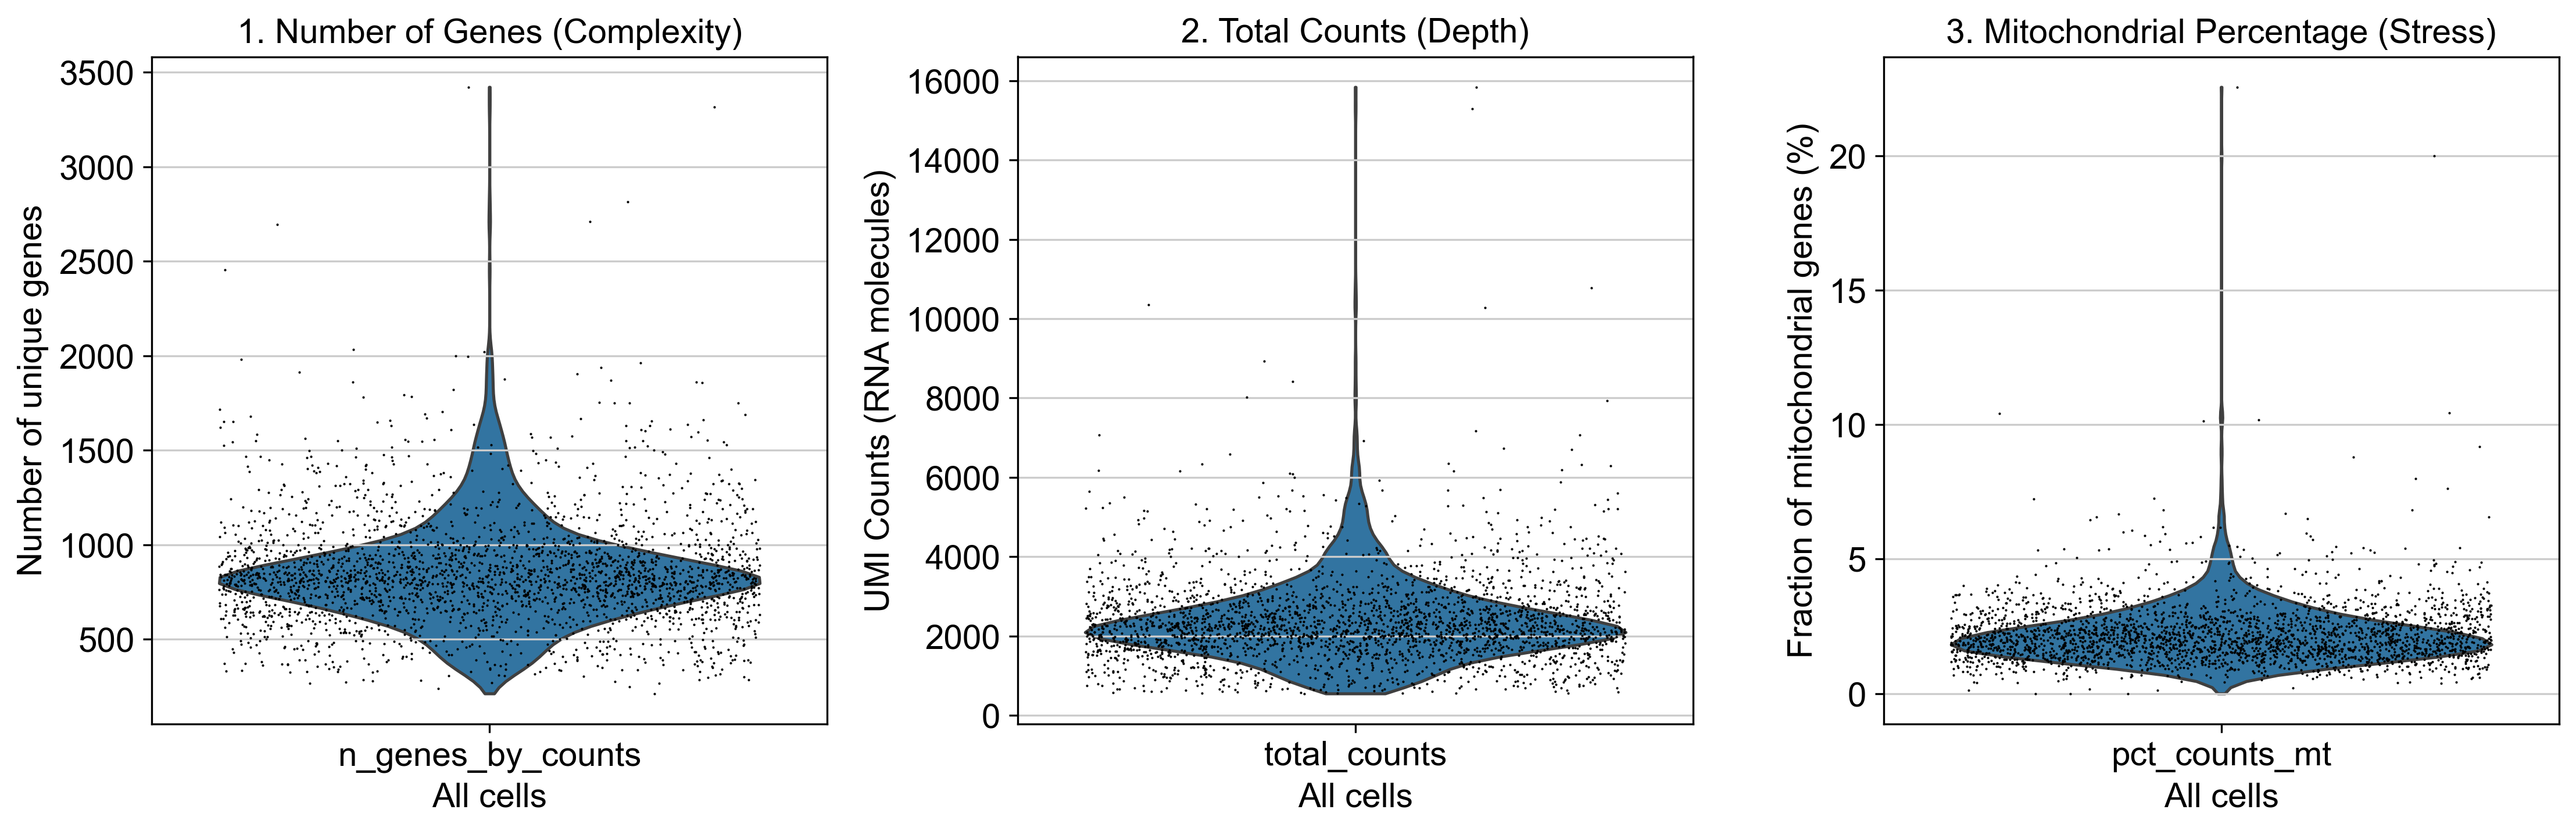

In [272]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sc.pl.violin(adata, 'n_genes_by_counts', ax=axs[0], show=False, jitter=0.4)
axs[0].set_title("1. Number of Genes (Complexity)", fontsize=14)
axs[0].set_ylabel("Number of unique genes")
axs[0].set_xlabel("All cells")


sc.pl.violin(adata, 'total_counts', ax=axs[1], show=False, jitter=0.4)
axs[1].set_title("2. Total Counts (Depth)", fontsize=14)
axs[1].set_ylabel("UMI Counts (RNA molecules)")
axs[1].set_xlabel("All cells")


sc.pl.violin(adata, 'pct_counts_mt', ax=axs[2], show=False, jitter=0.4)
axs[2].set_title("3. Mitochondrial Percentage (Stress)", fontsize=14)
axs[2].set_ylabel("Fraction of mitochondrial genes (%)")
axs[2].set_xlabel("All cells")

save_path = os.path.join(figures_folder, "violin_plots.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 5. Visual Inspection: Correlation of QC Metrics

**Why we do this:**
Scatter plots help us identify technical artifacts that single-metric violin plots might miss. By plotting metrics against each other, we can verify data integrity (e.g., sequencing depth should correlate with gene count) and precisely locate the population of stressed cells (high mitochondrial content but low gene counts).

**How we do this:**
We generate two scatter plots:
1. **Depth vs. Complexity:** Checks for technical consistency.
2. **Mito % vs. Complexity:** Critical for setting the filtration cutoff. We color points by a third variable to visualize interactions between metrics.

**Expected Results:**
* **Left:** A strong positive correlation (diagonal trend), confirming good technical quality.
* **Right:** A distinct "vertical tail" of cells with high mitochondrial percentage (>5%) and low gene counts. This visually justifies our upcoming 5% cutoff for filtering.

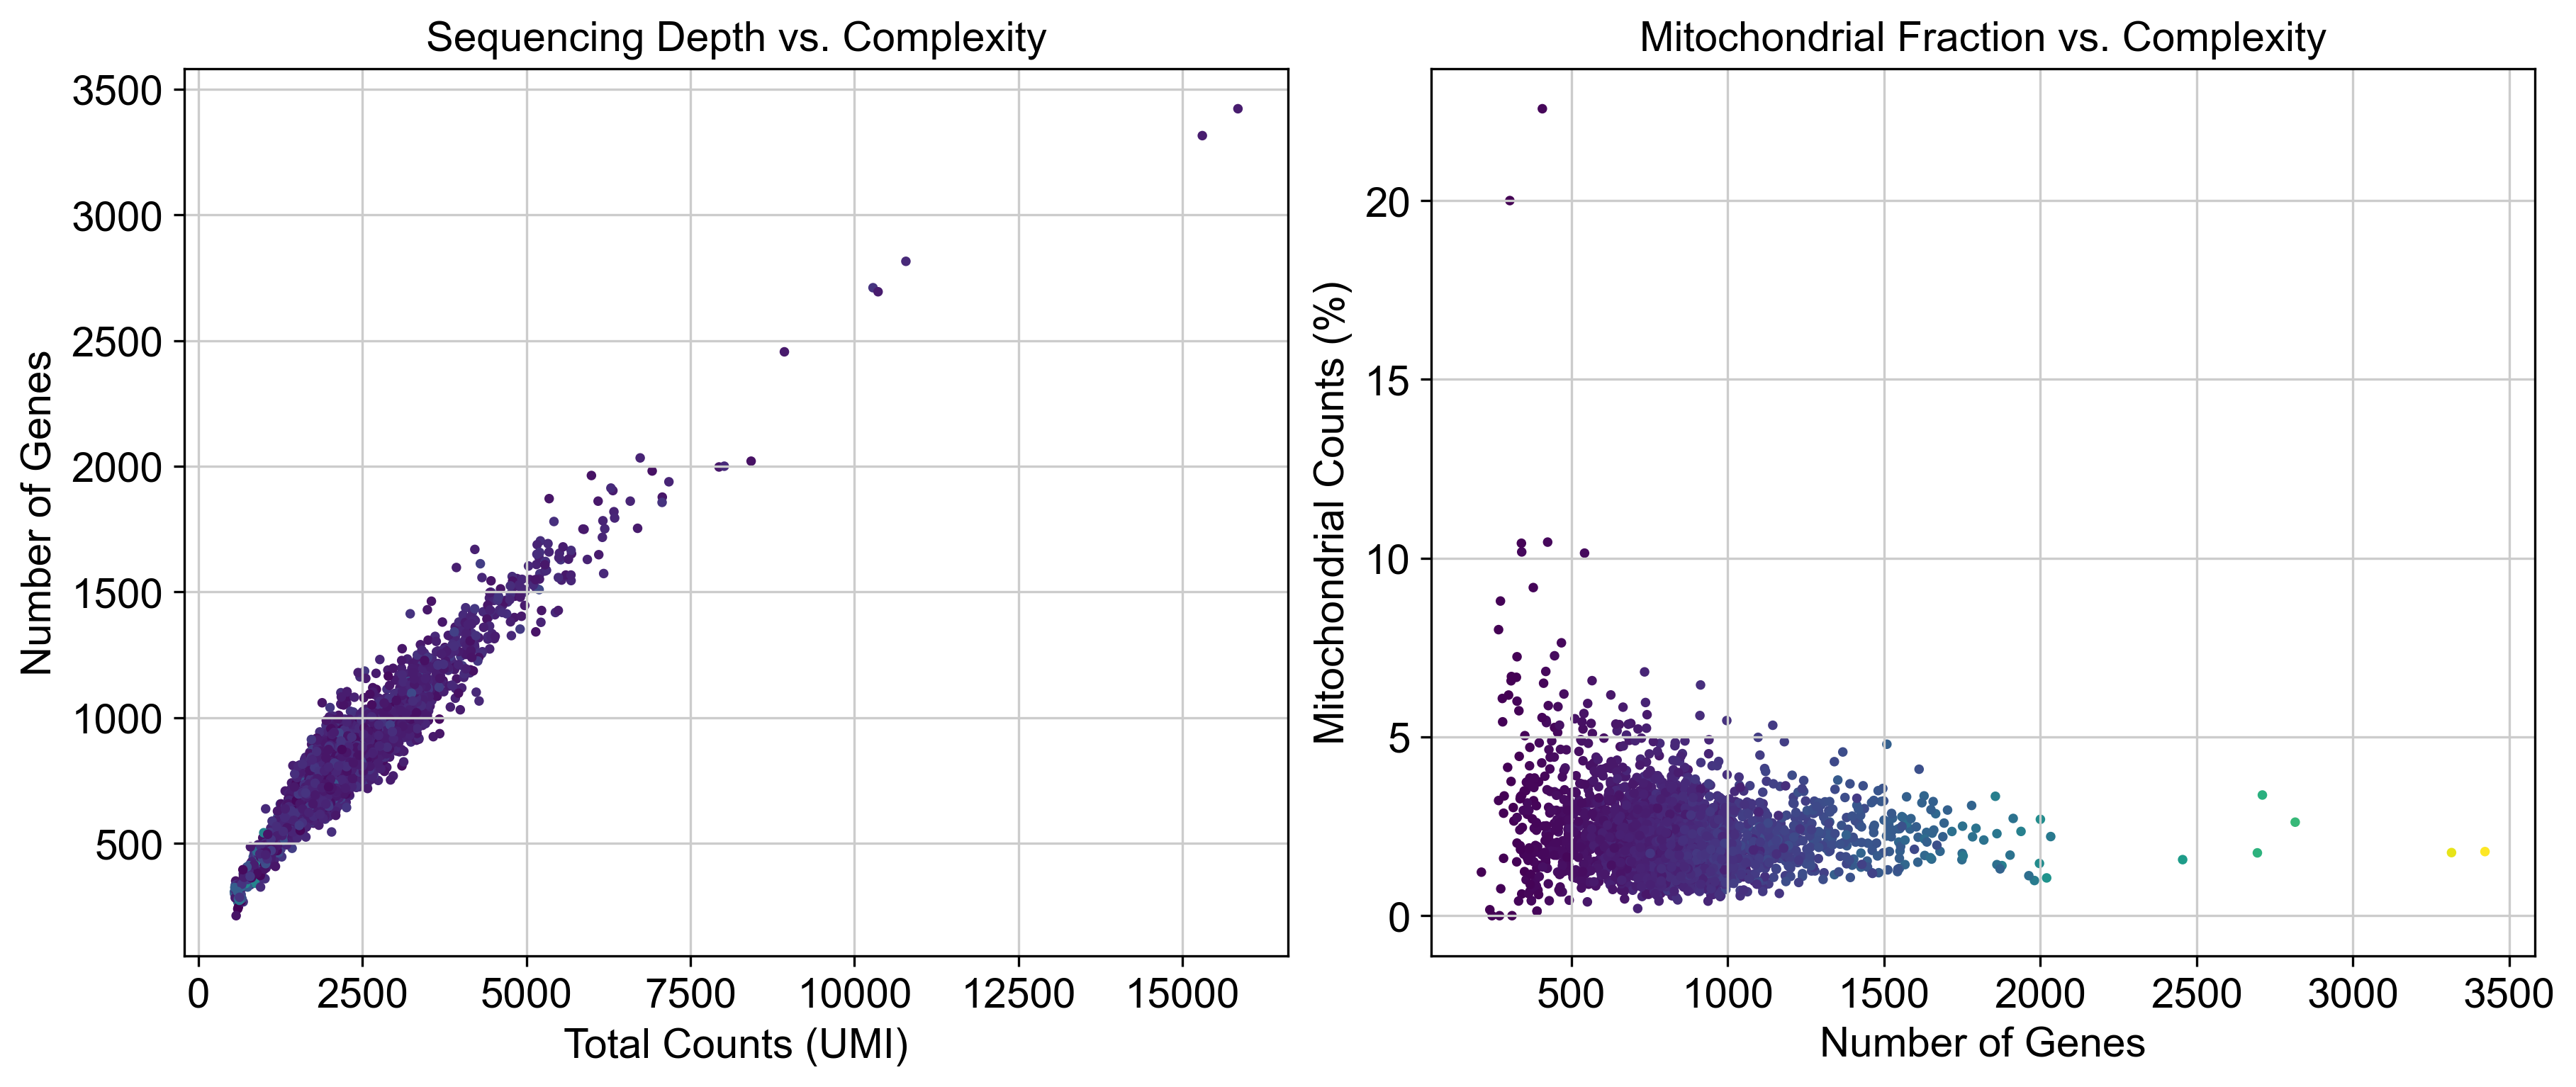

In [273]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)


axs[0].scatter(
    adata.obs['total_counts'],      
    adata.obs['n_genes_by_counts'], 
    c=adata.obs['pct_counts_mt'],  
    s=5,                           
    cmap='viridis',
)
axs[0].set_title("Sequencing Depth vs. Complexity", fontsize=14)
axs[0].set_xlabel("Total Counts (UMI)")
axs[0].set_ylabel("Number of Genes")


axs[1].scatter(
    adata.obs['n_genes_by_counts'], 
    adata.obs['pct_counts_mt'],     
    c=adata.obs['total_counts'],    
    s=5,                            
    cmap='viridis',
    
)
axs[1].set_title("Mitochondrial Fraction vs. Complexity", fontsize=14)
axs[1].set_xlabel("Number of Genes")
axs[1].set_ylabel("Mitochondrial Counts (%)")

save_path = os.path.join(figures_folder, "QC_scatter_plots.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

## 6. Defining Filtering Thresholds

**Why we do this:**
Based on the visual inspection of the quality control plots, we need to establish quantitative rules to distinguish between healthy cells, empty droplets, and stressed cells. Setting these thresholds now allows us to quantify the impact of filtering before permanently altering the dataset.

**How we do this:**
We define constants for the minimum number of genes per cell (200) to remove empty droplets, a maximum mitochondrial percentage (5%) to remove dying cells, and a minimum prevalence for genes (3 cells) to remove noise. We then calculate how many cells and genes fail these specific criteria.

**Expected Results:**
A printout summarizing the "Filtering Plan." We expect to see that a small percentage of cells (the outliers identified in the plots) will be removed, while the vast majority of the data is retained.

In [274]:
MIN_GENES = 200
MAX_MT_PCT = 5
MIN_CELLS_PER_GENE = 3

n_cells_orig = adata.n_obs
n_genes_orig = adata.n_vars

print(f"--- Filtering Plan ---")
print(f"Original dataset: {n_cells_orig} cells, {n_genes_orig} genes")


logging.info(f"--- Filtering Plan ---")
logging.info(f"Original dataset: {n_cells_orig} cells, {n_genes_orig} genes")

n_bad_genes = (adata.obs['n_genes_by_counts'] < MIN_GENES).sum()
n_high_mt = (adata.obs['pct_counts_mt'] > MAX_MT_PCT).sum()
n_rare_genes = (adata.var['n_cells_by_counts'] < MIN_CELLS_PER_GENE).sum()

print(f"\nCells to be removed:")
print(f" - Low complexity (< {MIN_GENES} genes): {n_bad_genes}")
print(f" - High mitochondrial stress (> {MAX_MT_PCT}%): {n_high_mt}")
print(f"\nGenes to be removed:")
print(f" - Rare genes (< {MIN_CELLS_PER_GENE} cells): {n_rare_genes}")

logging.info(f"\nCells to be removed:")
logging.info(f" - Low complexity (< {MIN_GENES} genes): {n_bad_genes}")
logging.info(f" - High mitochondrial stress (> {MAX_MT_PCT}%): {n_high_mt}")
logging.info(f"\nGenes to be removed:")
logging.info(f" - Rare genes (< {MIN_CELLS_PER_GENE} cells): {n_rare_genes}")

--- Filtering Plan ---
Original dataset: 2700 cells, 32738 genes
20:44:06 - --- Filtering Plan ---
20:44:06 - Original dataset: 2700 cells, 32738 genes

Cells to be removed:
 - Low complexity (< 200 genes): 0
 - High mitochondrial stress (> 5%): 57

Genes to be removed:
 - Rare genes (< 3 cells): 19024
20:44:06 - 
Cells to be removed:
20:44:06 -  - Low complexity (< 200 genes): 0
20:44:06 -  - High mitochondrial stress (> 5%): 57
20:44:06 - 
Genes to be removed:
20:44:06 -  - Rare genes (< 3 cells): 19024


## 7. Applying Filtration and Verification

**Why we do this:**
We execute the actual removal of low-quality data points to ensure downstream analysis (like PCA and clustering) is performed only on healthy, biological signals. We immediately visualize the data again to verify that the "bad" cells were successfully removed.

**How we do this:**
We apply the filters defined in the previous step using Scanpy's preprocessing functions and array slicing. Afterward, we regenerate the scatter plots for Sequencing Depth and Mitochondrial Fraction using the cleaned dataset. Note that we do not filter by maximum genes yet; we reserve doublet detection for the dedicated Scrublet step.

**Expected Results:**
The dataset size will decrease slightly. The resulting scatter plots should look cleaner: the "tail" of high-mitochondrial cells in the second plot should be completely gone, leaving only the dense cluster of healthy cells.


--- Applying Filters ---
20:44:06 - 
--- Applying Filters ---
Filtering complete.
Remaining cells: 2643 (Removed: 57)
Remaining genes: 13697 (Removed: 19041)
20:44:06 - Filtering complete.
20:44:06 - Remaining cells: 2643 (Removed: 57)
20:44:06 - Remaining genes: 13697 (Removed: 19041)


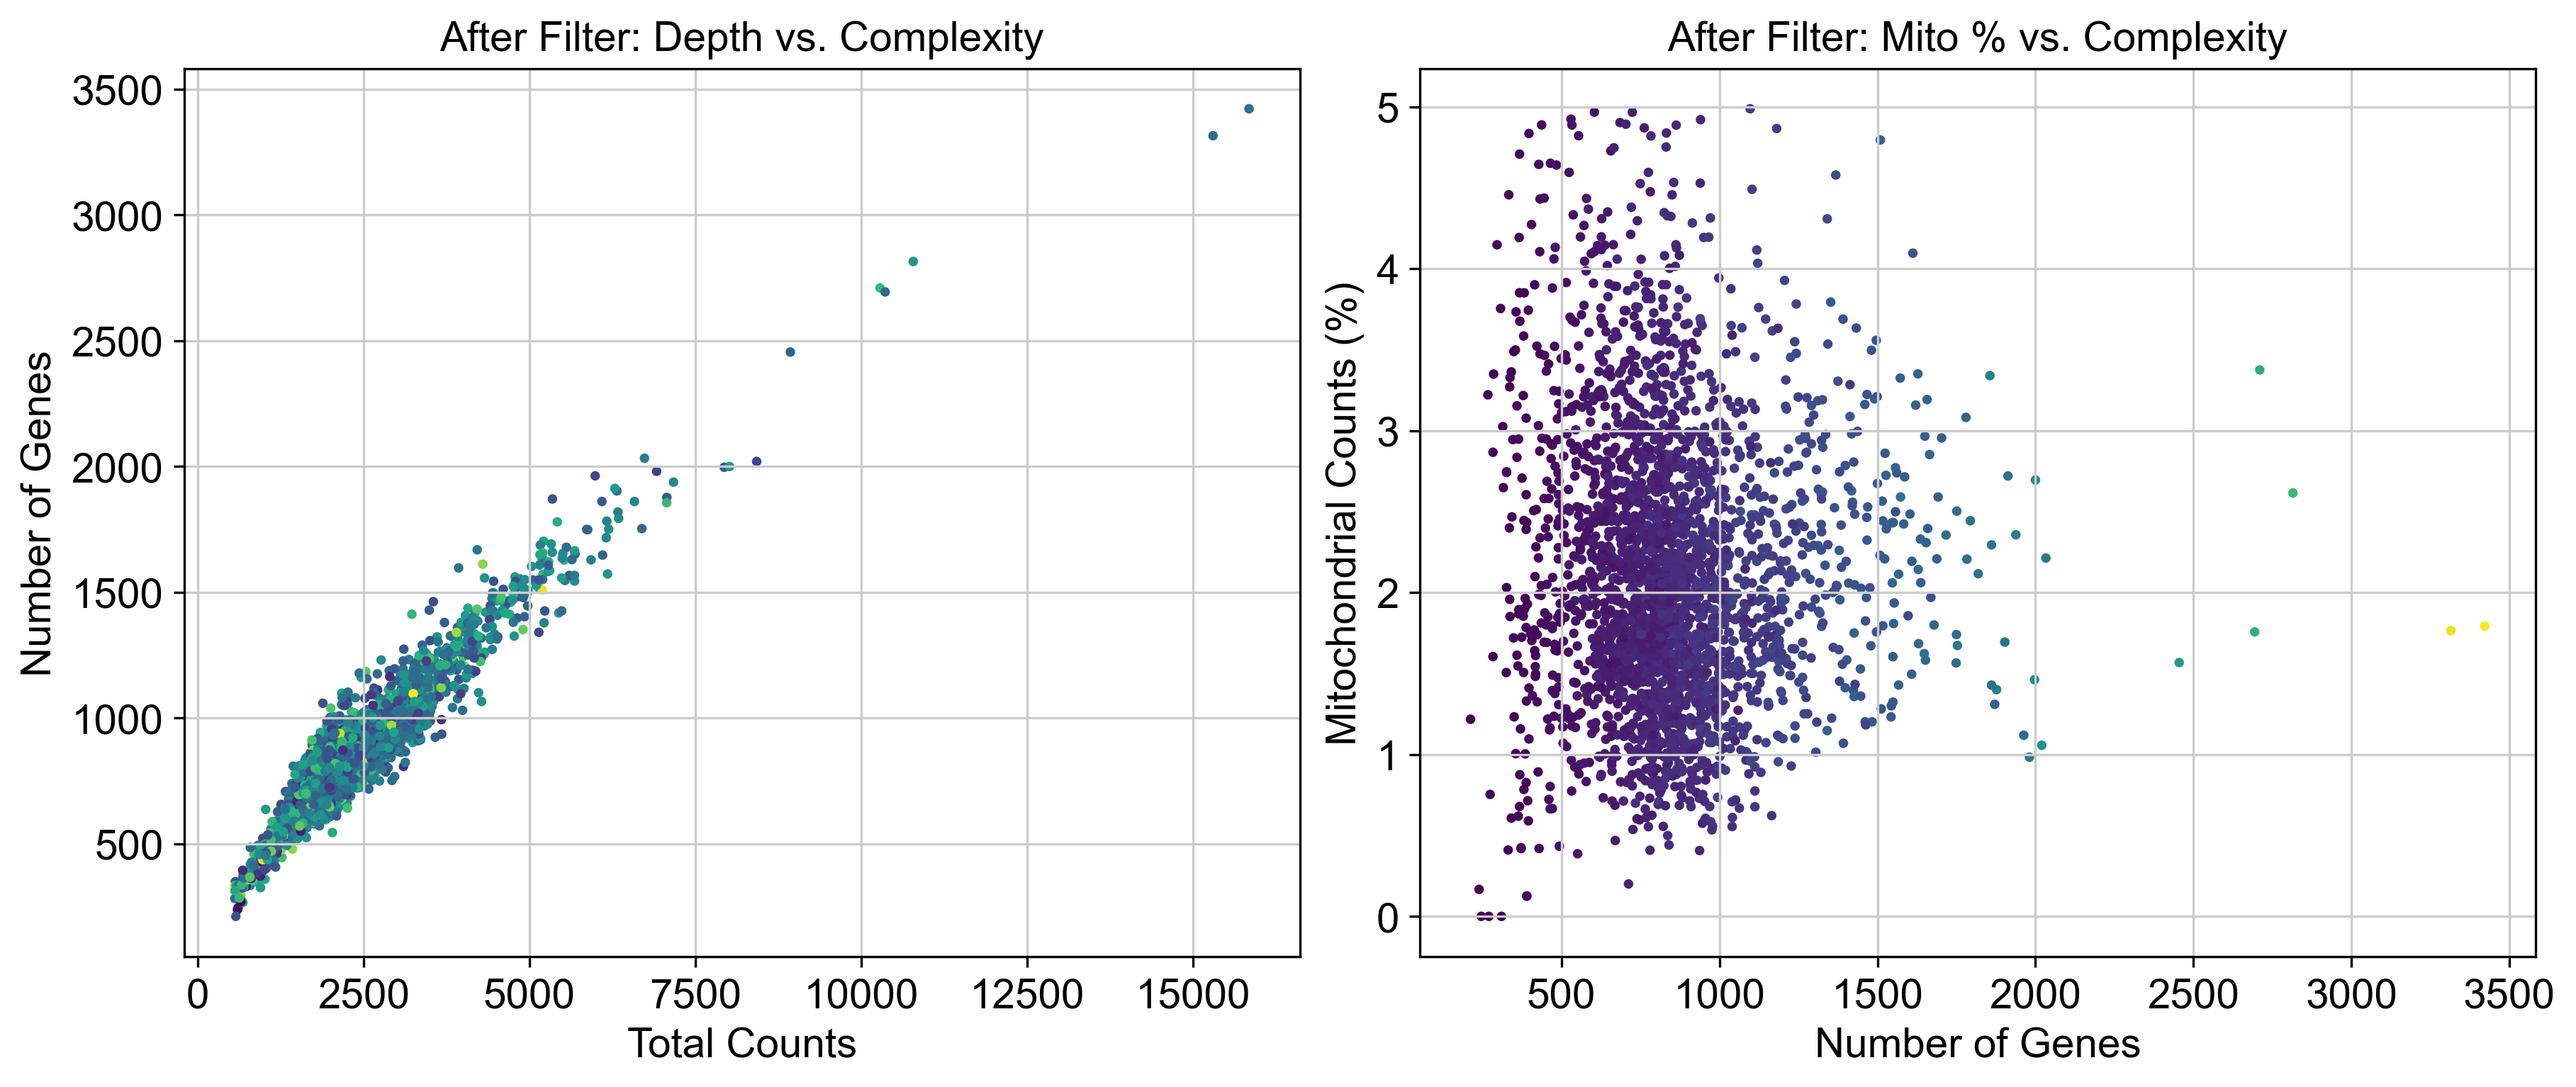

In [275]:
import matplotlib.pyplot as plt

print("\n--- Applying Filters ---")
logging.info("\n--- Applying Filters ---")

sc.pp.filter_cells(adata, min_genes=MIN_GENES)
adata = adata[adata.obs['pct_counts_mt'] < MAX_MT_PCT, :].copy()
sc.pp.filter_genes(adata, min_cells=MIN_CELLS_PER_GENE)

print(f"Filtering complete.")
print(f"Remaining cells: {adata.n_obs} (Removed: {n_cells_orig - adata.n_obs})")
print(f"Remaining genes: {adata.n_vars} (Removed: {n_genes_orig - adata.n_vars})")

logging.info(f"Filtering complete.")
logging.info(f"Remaining cells: {adata.n_obs} (Removed: {n_cells_orig - adata.n_obs})")
logging.info(f"Remaining genes: {adata.n_vars} (Removed: {n_genes_orig - adata.n_vars})")

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

axs[0].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], c=adata.obs['pct_counts_mt'], s=5, cmap='viridis')
axs[0].set_title("After Filter: Depth vs. Complexity", fontsize=14)
axs[0].set_xlabel("Total Counts")
axs[0].set_ylabel("Number of Genes")

axs[1].scatter(adata.obs['n_genes_by_counts'], adata.obs['pct_counts_mt'], c=adata.obs['total_counts'], s=5, cmap='viridis')
axs[1].set_title("After Filter: Mito % vs. Complexity", fontsize=14)
axs[1].set_xlabel("Number of Genes")
axs[1].set_ylabel("Mitochondrial Counts (%)")

save_path = os.path.join(figures_folder, "filter_verification_scatter_plot.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

## 8. Doublet Detection with Scrublet

**Why we do this:**
Doublets (two cells sequenced as one) create artificial hybrid profiles that distort clustering results. We must identify and remove these technical artifacts to ensure analysis accuracy.

**How we do this:**
We use the **Scrublet** algorithm, which simulates artificial doublets from the dataset and compares them to real cells. Each cell is assigned a `doublet_score` based on its similarity to the simulated doublets.

**Expected Results:**
A bimodal histogram distinguishing singlets (low scores) from doublets (high scores). Scrublet automatically determines a threshold and adds a `predicted_doublet` column to the metadata.

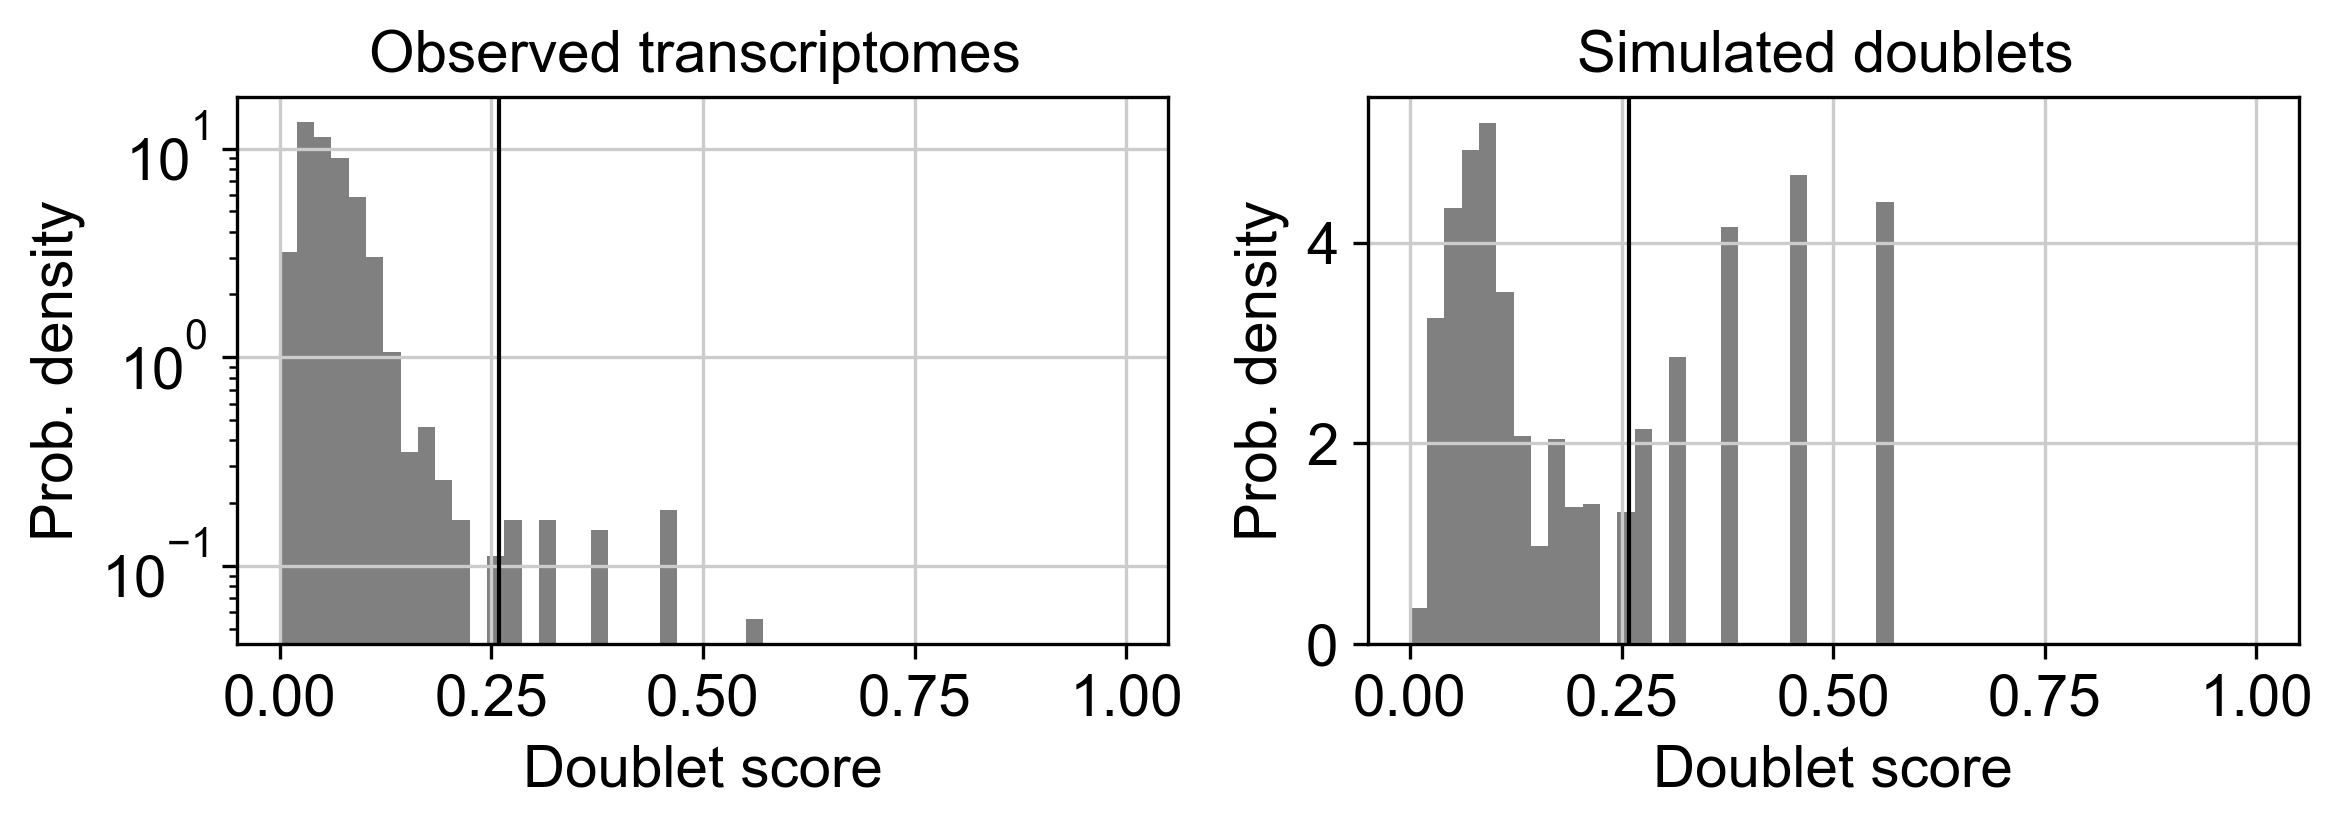

Scrublet run complete.
Predicted doublets: 39
Predicted singlet/doublet ratio:
predicted_doublet
False    2604
True       39
Name: count, dtype: int64
20:44:10 - Scrublet run complete.
20:44:10 - Predicted doublets: 39
20:44:10 - Predicted singlet/doublet ratio:
predicted_doublet
False    2604
True       39
Name: count, dtype: int64


In [276]:
sc.pp.scrublet(adata, expected_doublet_rate=0.06)

sc.pl.scrublet_score_distribution(adata, show=True)

n_predicted_doublets = adata.obs['predicted_doublet'].sum()
print(f"Scrublet run complete.")
print(f"Predicted doublets: {n_predicted_doublets}")
print(f"Predicted singlet/doublet ratio:\n{adata.obs['predicted_doublet'].value_counts()}")

logging.info(f"Scrublet run complete.")
logging.info(f"Predicted doublets: {n_predicted_doublets}")
logging.info(f"Predicted singlet/doublet ratio:\n{adata.obs['predicted_doublet'].value_counts()}")

## 9. Doublet Removal and Normalization

**Why we do this:**
After identifying potential doublets in the previous step, we must now physically remove them from the dataset to prevent them from distorting our analysis. Following this, we perform normalization to make the gene expression counts comparable between cells (accounting for differences in sequencing depth) and apply a logarithmic transformation to stabilize the variance of the data.

**How we do this:**
1. **Filtering:** We subset the data to keep only cells marked as `False` in the `predicted_doublet` column.
2. **Normalization:** We scale the counts in each cell so they sum to a fixed total (10,000).
3. **Transformation:** We apply a natural logarithm ($\ln(x+1)$) to the normalized counts.

**Expected Results:**
The dataset size will decrease by the number of detected doublets. The data values will change from raw integers to normalized, log-transformed floats, ready for statistical analysis.

In [277]:
n_doublets = adata.obs['predicted_doublet'].sum()
n_obs_before = adata.n_obs

adata = adata[adata.obs['predicted_doublet'] == False, :].copy()

print(f"Doublet filtering complete.")
print(f"Removed doublets: {n_doublets}")
print(f"Remaining cells: {adata.n_obs}")

logging.info(f"Doublet filtering complete.")
logging.info(f"Removed doublets: {n_doublets}")
logging.info(f"Remaining cells: {adata.n_obs}")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print(f"Data normalized (10k) and log-transformed.")
logging.info(f"Data normalized (10k) and log-transformed.")

Doublet filtering complete.
Removed doublets: 39
Remaining cells: 2604
20:44:10 - Doublet filtering complete.
20:44:10 - Removed doublets: 39
20:44:10 - Remaining cells: 2604
Data normalized (10k) and log-transformed.
20:44:10 - Data normalized (10k) and log-transformed.


## 10. Feature Selection (Highly Variable Genes)

**Why we do this:**
Single-cell datasets contain thousands of genes, but most are "uninformative" (expressed at constant low levels or not at all). To improve the signal-to-noise ratio and computational efficiency, we focus only on **Highly Variable Genes (HVGs)**—genes that show significant variation across cells, as these are likely to define biological cell types.

**How we do this:**
1. **Identification:** We calculate the mean and dispersion for each gene and select the top 2,000 with the highest variability.
2. **Visualization:** We plot the relationship between mean expression and dispersion to visualize the selection.
3. **Preservation:** We save the current state (normalized, log-transformed, containing *all* genes) into `adata.raw`. This is crucial for later steps like marker gene identification.
4. **Filtering:** We slice the main `adata` object to keep *only* the 2,000 HVGs.

**Expected Results:**
A plot showing the selected variable genes (black points) vs. non-variable genes (grey points). The dataset's width (number of variables/genes) will be drastically reduced from ~13,000 to 2,000, significantly reducing dimensionality.

Highly variable genes identified: 2000
Highly variable genes identified: 2000


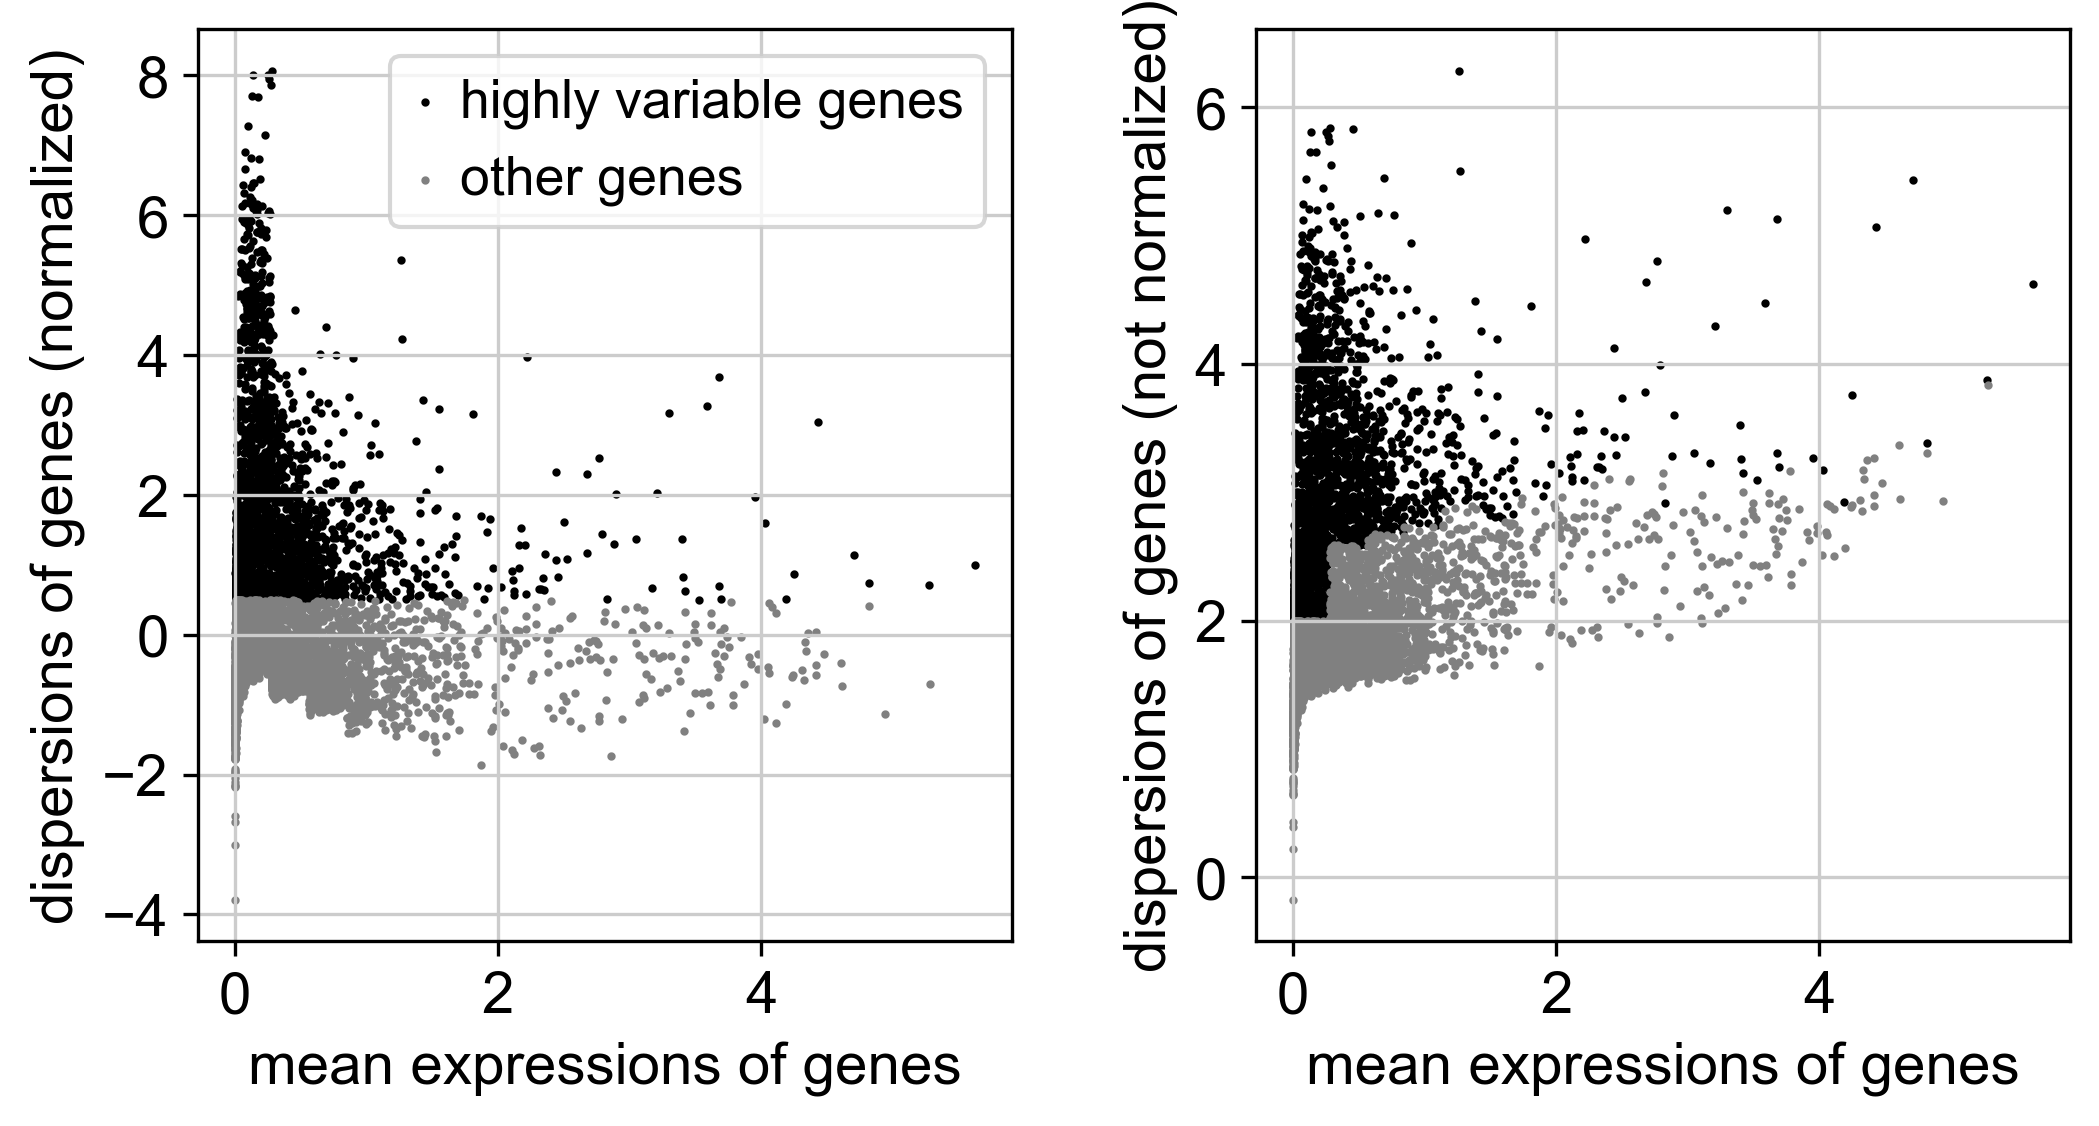

Data filtering complete.
Original gene count (in .raw): 13697
Current gene count (HVGs only): 2000
20:44:11 - Data filtering complete.
20:44:11 - Original gene count (in .raw): 13697
20:44:11 - Current gene count (HVGs only): 2000


In [278]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

print(f"Highly variable genes identified: {adata.var.highly_variable.sum()}")
print(f"Highly variable genes identified: {adata.var.highly_variable.sum()}")
sc.pl.highly_variable_genes(adata, show=True, save='HVG_plots.png')

adata.raw = adata

adata = adata[:, adata.var.highly_variable].copy()

print(f"Data filtering complete.")
print(f"Original gene count (in .raw): {adata.raw.n_vars}")
print(f"Current gene count (HVGs only): {adata.n_vars}")

logging.info(f"Data filtering complete.")
logging.info(f"Original gene count (in .raw): {adata.raw.n_vars}")
logging.info(f"Current gene count (HVGs only): {adata.n_vars}")

## 11. Scaling and Dimensionality Reduction (PCA)

**Why we do this:**
Before performing dimensionality reduction, we must scale the data so that highly expressed genes do not dominate the analysis purely due to their magnitude. We then use Principal Component Analysis (PCA) to reduce the data from ~2,000 genes to 50 essential components (axes of variation), capturing the biological signal while discarding noise.

**How we do this:**
1. **Scaling:** We scale the data to unit variance (Z-score) with a maximum value clip to mitigate outliers.
2. **PCA:** We calculate the first 50 principal components.
3. **Evaluation:** We plot the "Elbow Plot" (variance ratio) to visually confirm how many components contribute significant information.

**Expected Results:**
The dataset is standardized. The "Elbow Plot" should show a sharp drop in variance explained after the first few components, flattening out around 10-20 PCs, which confirms that 50 components are sufficient to capture the structure.

Data scaled (Z-score).
PCA computed.
Displaying Elbow Plot...


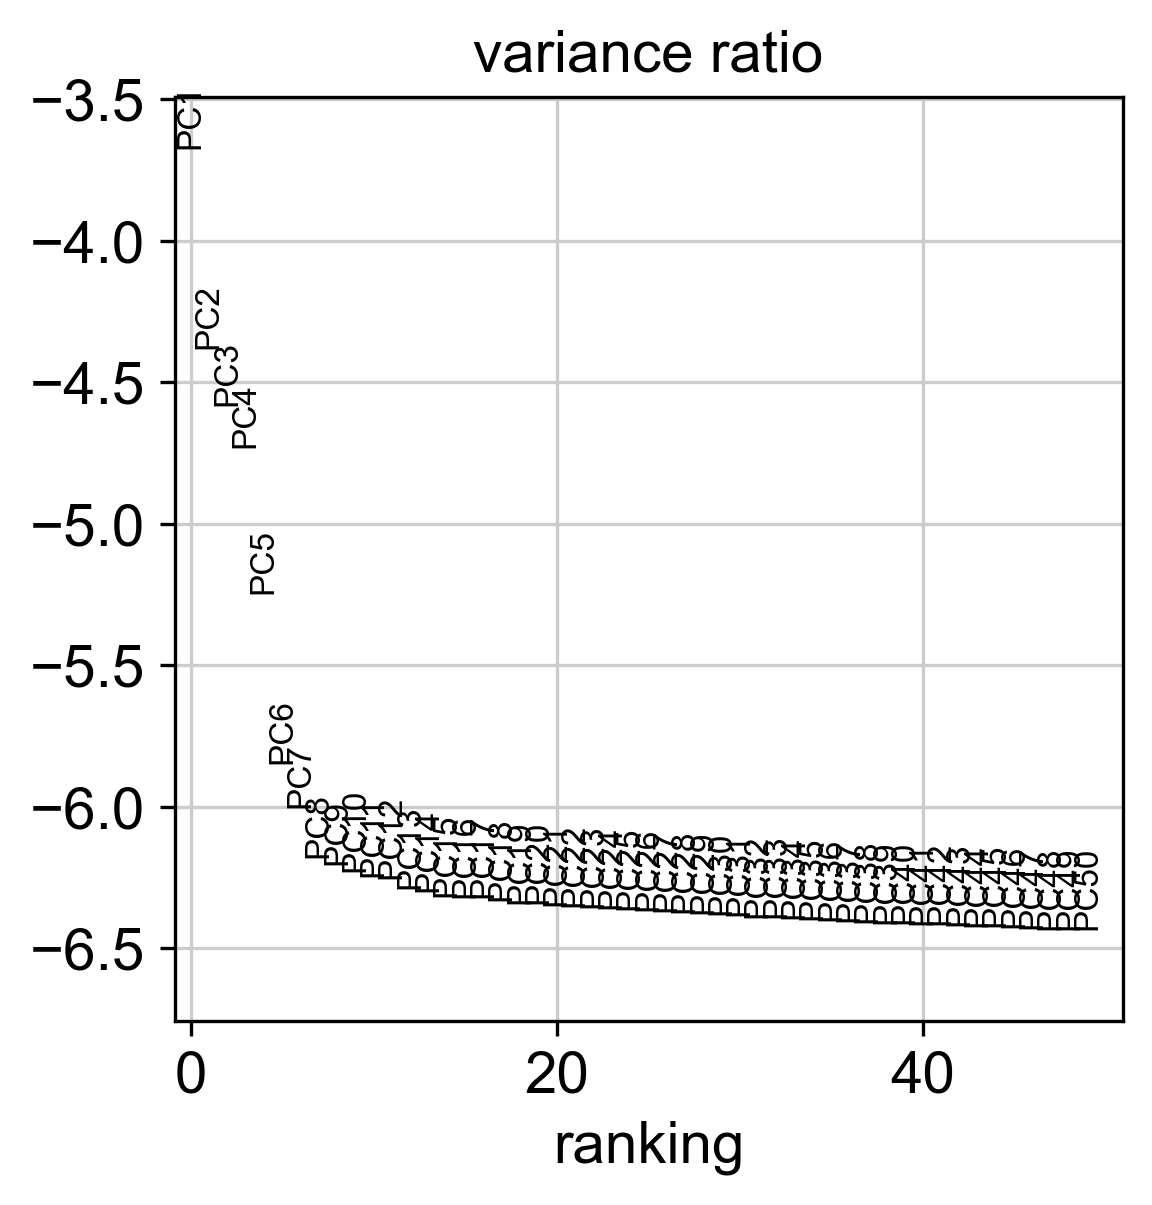

In [279]:
sc.pp.scale(adata, max_value=10)
print("Data scaled (Z-score).")

sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
print("PCA computed.")

print("Displaying Elbow Plot...")
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save='variance_ratio.png')

## 12. Neighborhood Graph and Clustering Sweep

**Why we do this:**
To identify cell types, we first need to understand the "neighborhood" structure of the data—which cells are similar to each other in the PCA space. We then apply the Leiden clustering algorithm. Since we do not know the "true" number of cell types beforehand, we test multiple resolution parameters to find the granularity that best represents the biological reality.

**How we do this:**
1. **Neighbors:** We construct a k-Nearest Neighbors (k-NN) graph using the first 20 PCs.
2. **UMAP:** We compute a UMAP embedding for 2D visualization.
3. **Leiden Sweep:** We iteratively run Leiden clustering with resolutions ranging from 0.3 (coarse) to 1.0 (fine) and visualize the results side-by-side.

**Expected Results:**
A series of UMAP plots showing how the number of clusters increases with resolution. We expect `resolution=0.3` to under-cluster (merge distinct types) and `resolution=1.0` to potentially over-cluster. Based on previous analysis, `0.8` is expected to be optimal.

Clustering complete for all resolutions.
                 leiden_res_0.3 leiden_res_0.5 leiden_res_0.6 leiden_res_0.7  \
index                                                                          
AAACATACAACCAC-1              0              0              0              0   
AAACATTGAGCTAC-1              3              2              3              3   
AAACATTGATCAGC-1              0              0              0              0   
AAACCGTGCTTCCG-1              1              1              2              2   
AAACCGTGTATGCG-1              2              5              6              6   

                 leiden_res_0.8 leiden_res_1.0  
index                                           
AAACATACAACCAC-1              0              0  
AAACATTGAGCTAC-1              3              3  
AAACATTGATCAGC-1              0              0  
AAACCGTGCTTCCG-1              2              5  
AAACCGTGTATGCG-1              6              6  


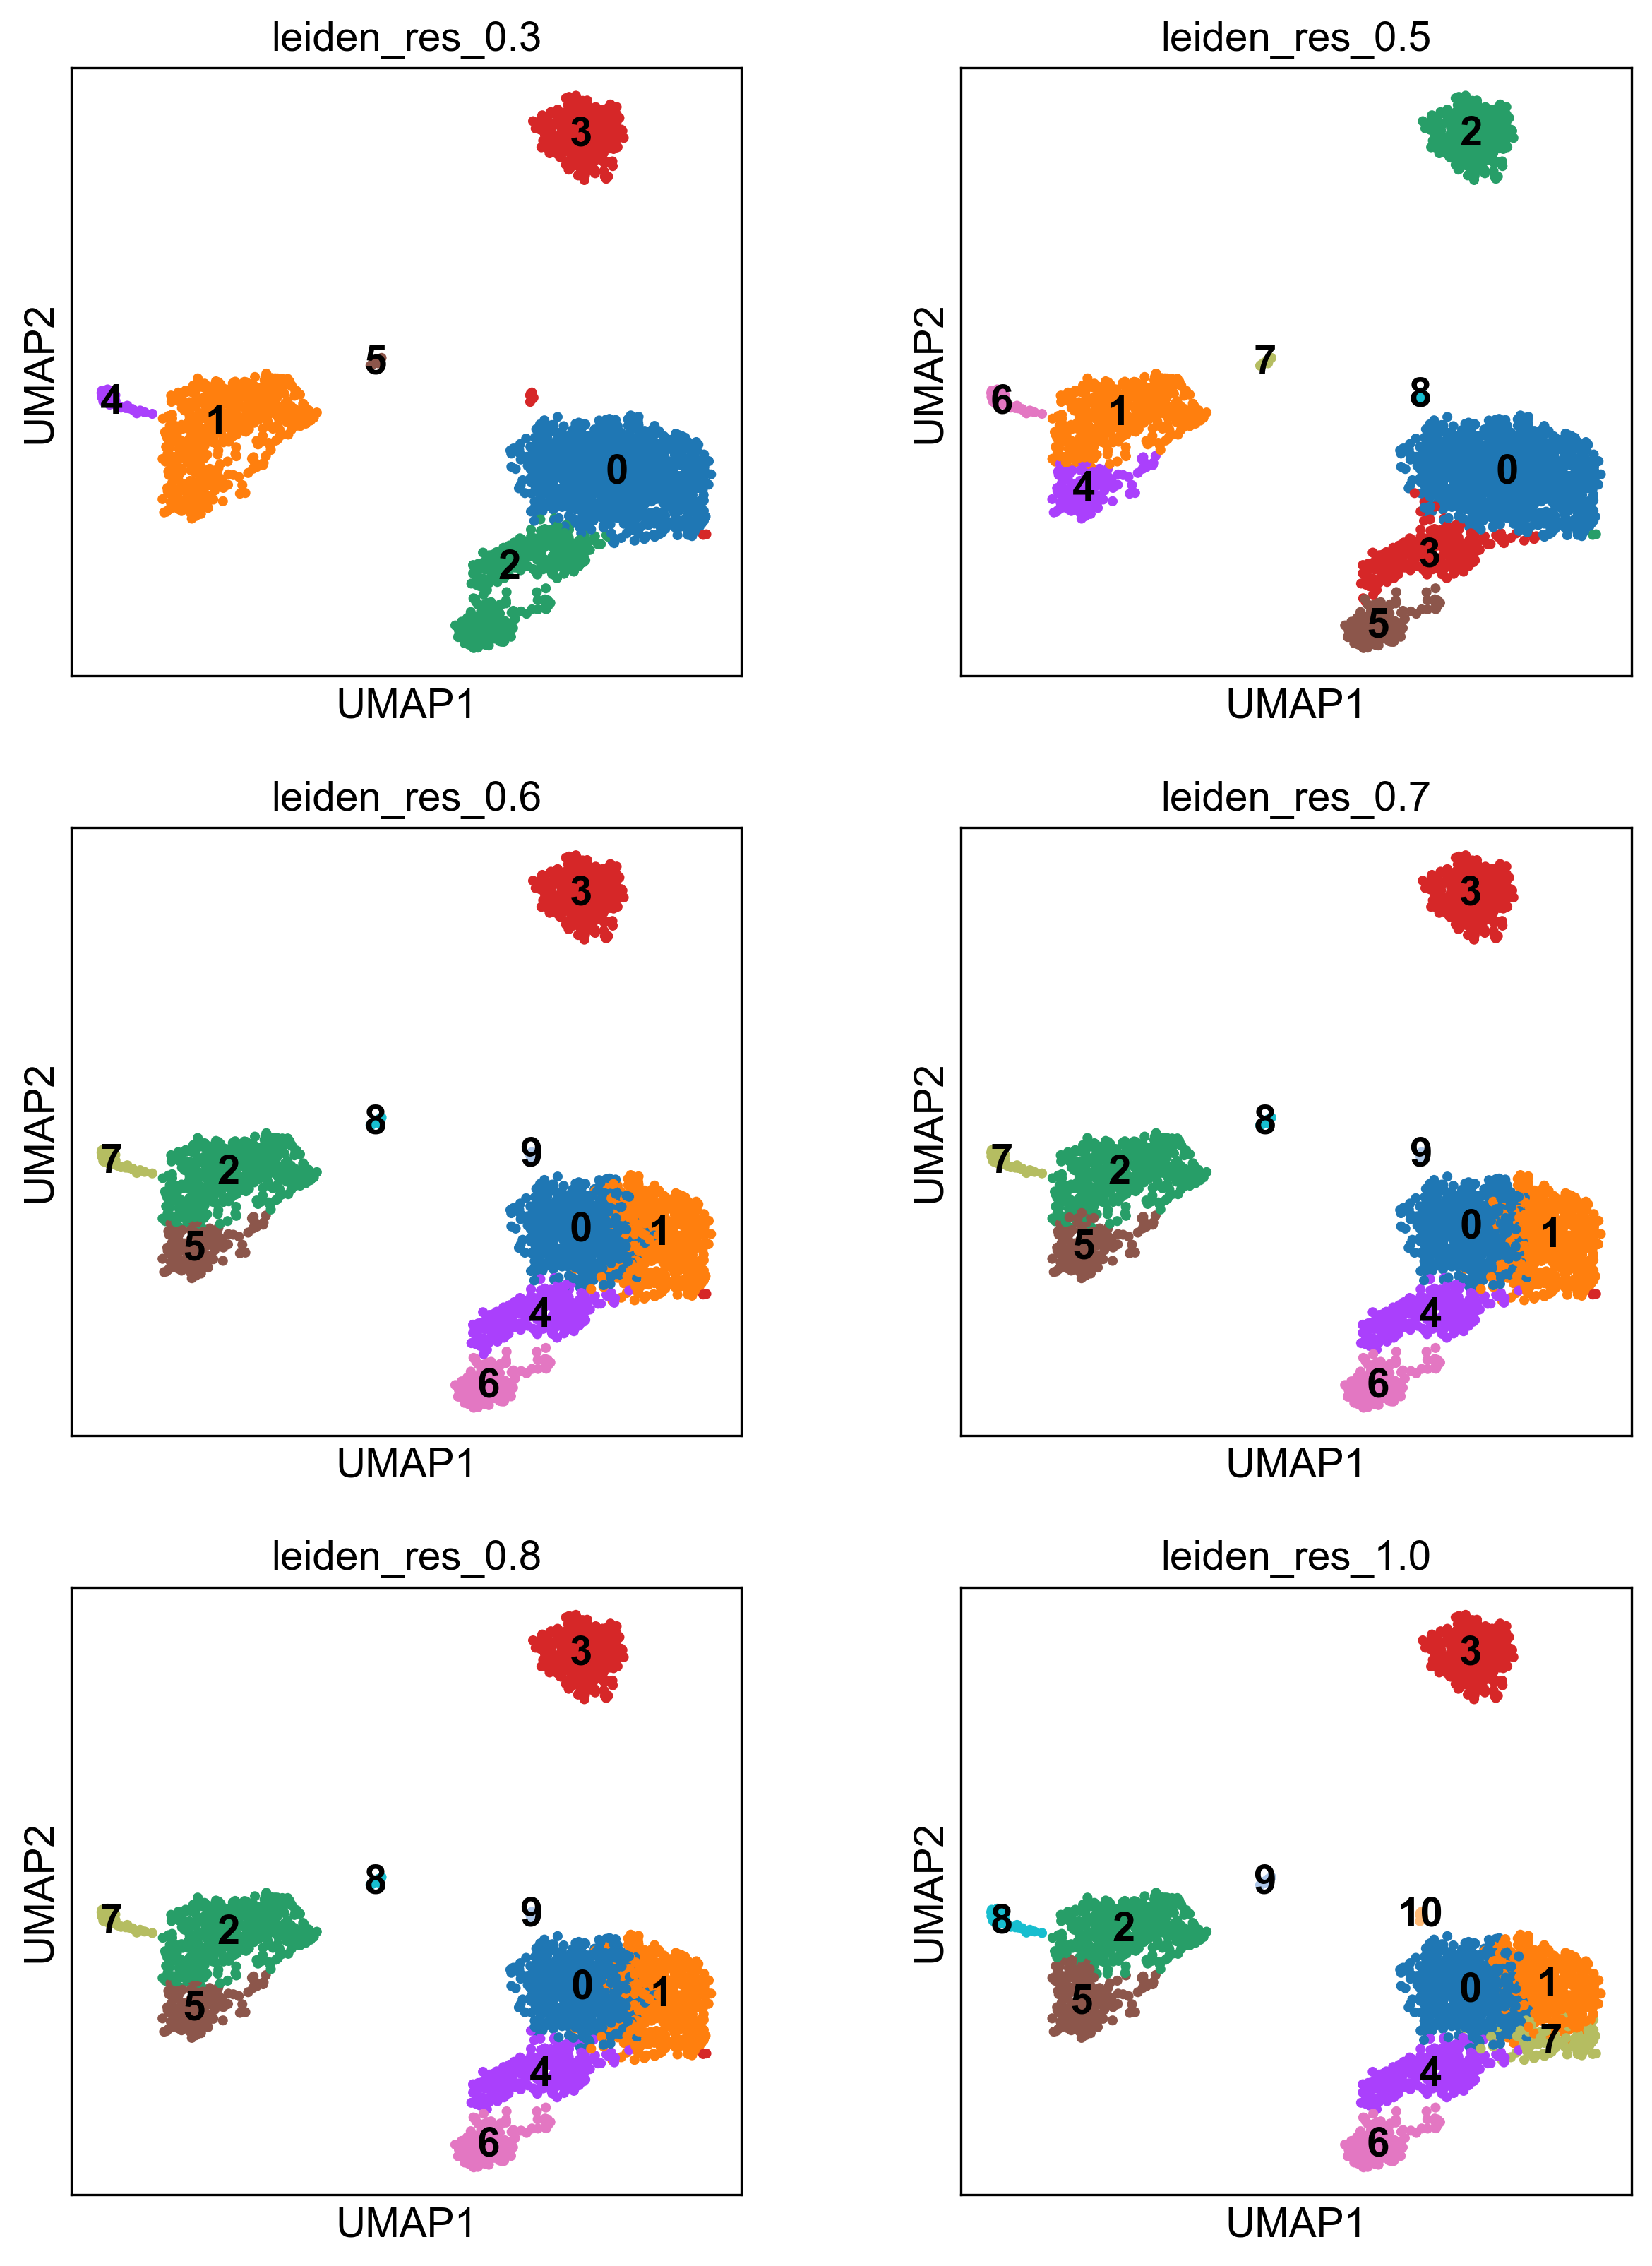

In [280]:
N_PCS_TO_USE = 20
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=N_PCS_TO_USE)

sc.tl.umap(adata)

resolutions_to_test = [0.3, 0.5, 0.6, 0.7, 0.8, 1.0]

for res in resolutions_to_test:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_res_{res}')

print("Clustering complete for all resolutions.")
print(adata.obs[[f'leiden_res_{res}' for res in resolutions_to_test]].head())

sc.pl.umap(
    adata,
    color=[f'leiden_res_{res}' for res in resolutions_to_test],
    legend_loc='on data',
    ncols=2,
    save='final_clustering.png'
)

## 13. Final Cluster Selection

**Why we do this:**
After inspecting the clustering sweep, we select the resolution that yields the most biologically interpretable results. Resolution 0.8 effectively separates known populations (like Monocytes vs. Dendritic cells) without artificially fragmenting homogeneous clusters. We lock this in as our final unsupervised model.

**How we do this:**
We copy the results from `leiden_res_0.8` into the main `leiden` column of the metadata. We then plot the final UMAP with this chosen clustering configuration.

**Expected Results:**
A single, clean UMAP plot showing approximately 8-9 distinct clusters, which will serve as the ground truth for our subsequent annotation and supervised learning steps.

Final clustering selected (Resolution 0.8):


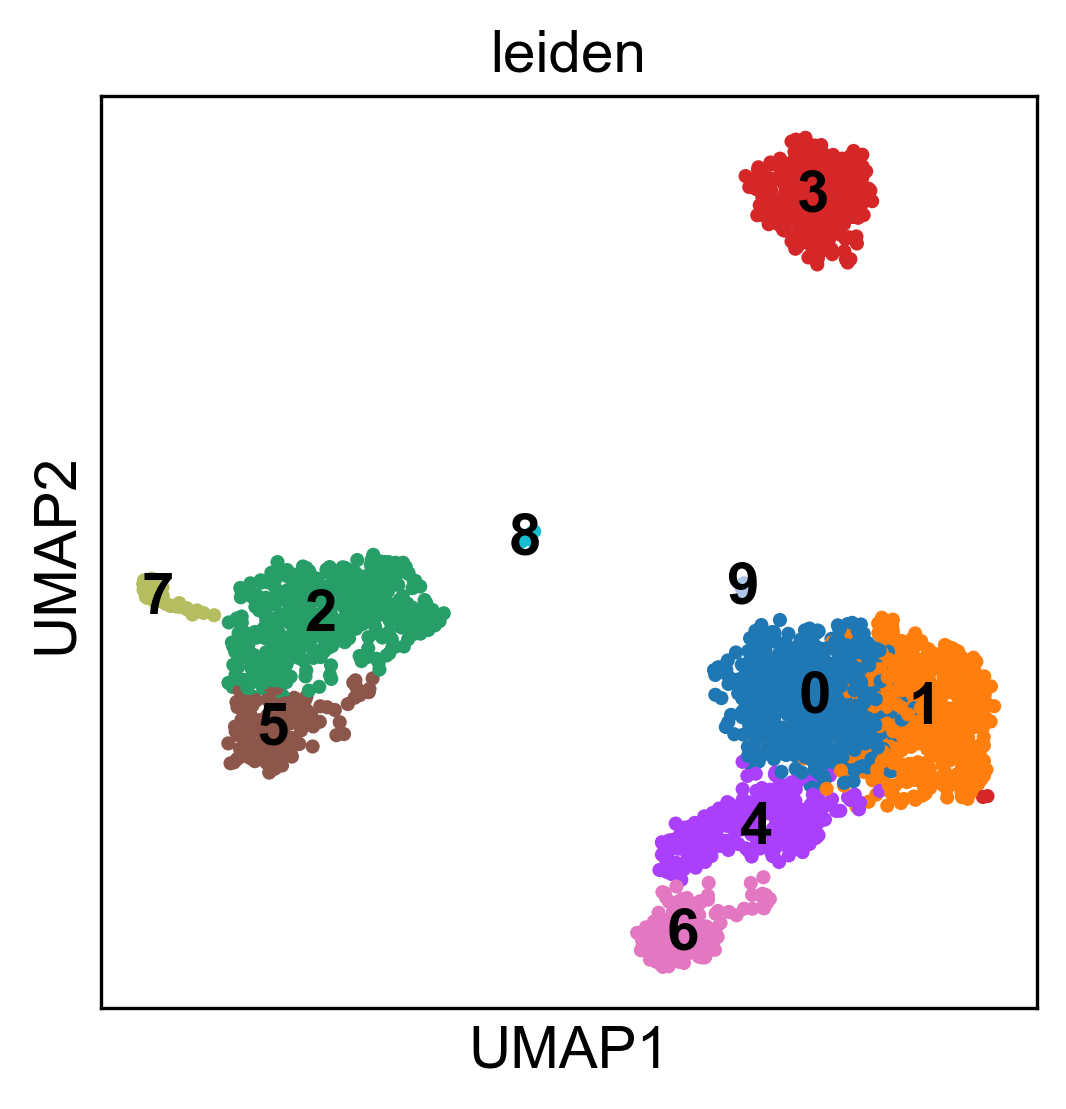

In [281]:
adata.obs['leiden'] = adata.obs['leiden_res_0.8'].copy()

print("Final clustering selected (Resolution 0.8):")
sc.pl.umap(adata, color='leiden', legend_loc='on data', show=True, save='umap_resolution.png')

## 13a. Method Comparison: Validation of Unsupervised Results

**Why we do this:**
To ensure our clustering results are robust and not just artifacts of a specific algorithm, we validate them using alternative methods. This satisfies the requirement to **compare metric-based recognition methods** (Outline Point 9) and **visualization techniques** (Outline Point 13).

**How we do this:**
1. **Visualization Comparison:** We compute **t-SNE**, a non-linear embedding method that emphasizes local structure, and compare it visually with **UMAP** (which balances local and global structure).
2. **Clustering Comparison:** We run **K-Means** (a centroid-based algorithm) set to find the same number of clusters ($k$) as our Leiden result. We then calculate the **Adjusted Rand Index (ARI)** to quantify the agreement between the two methods (1.0 = perfect match).

**Expected Results:**
t-SNE should show distinct clusters similar to UMAP but with different spatial arrangements. K-Means should largely agree with Leiden (high ARI > 0.5), confirming that the cell populations are distinct in the Euclidean PCA space.

Calculating t-SNE...
Calculating K-Means...
Visualizing comparisons...


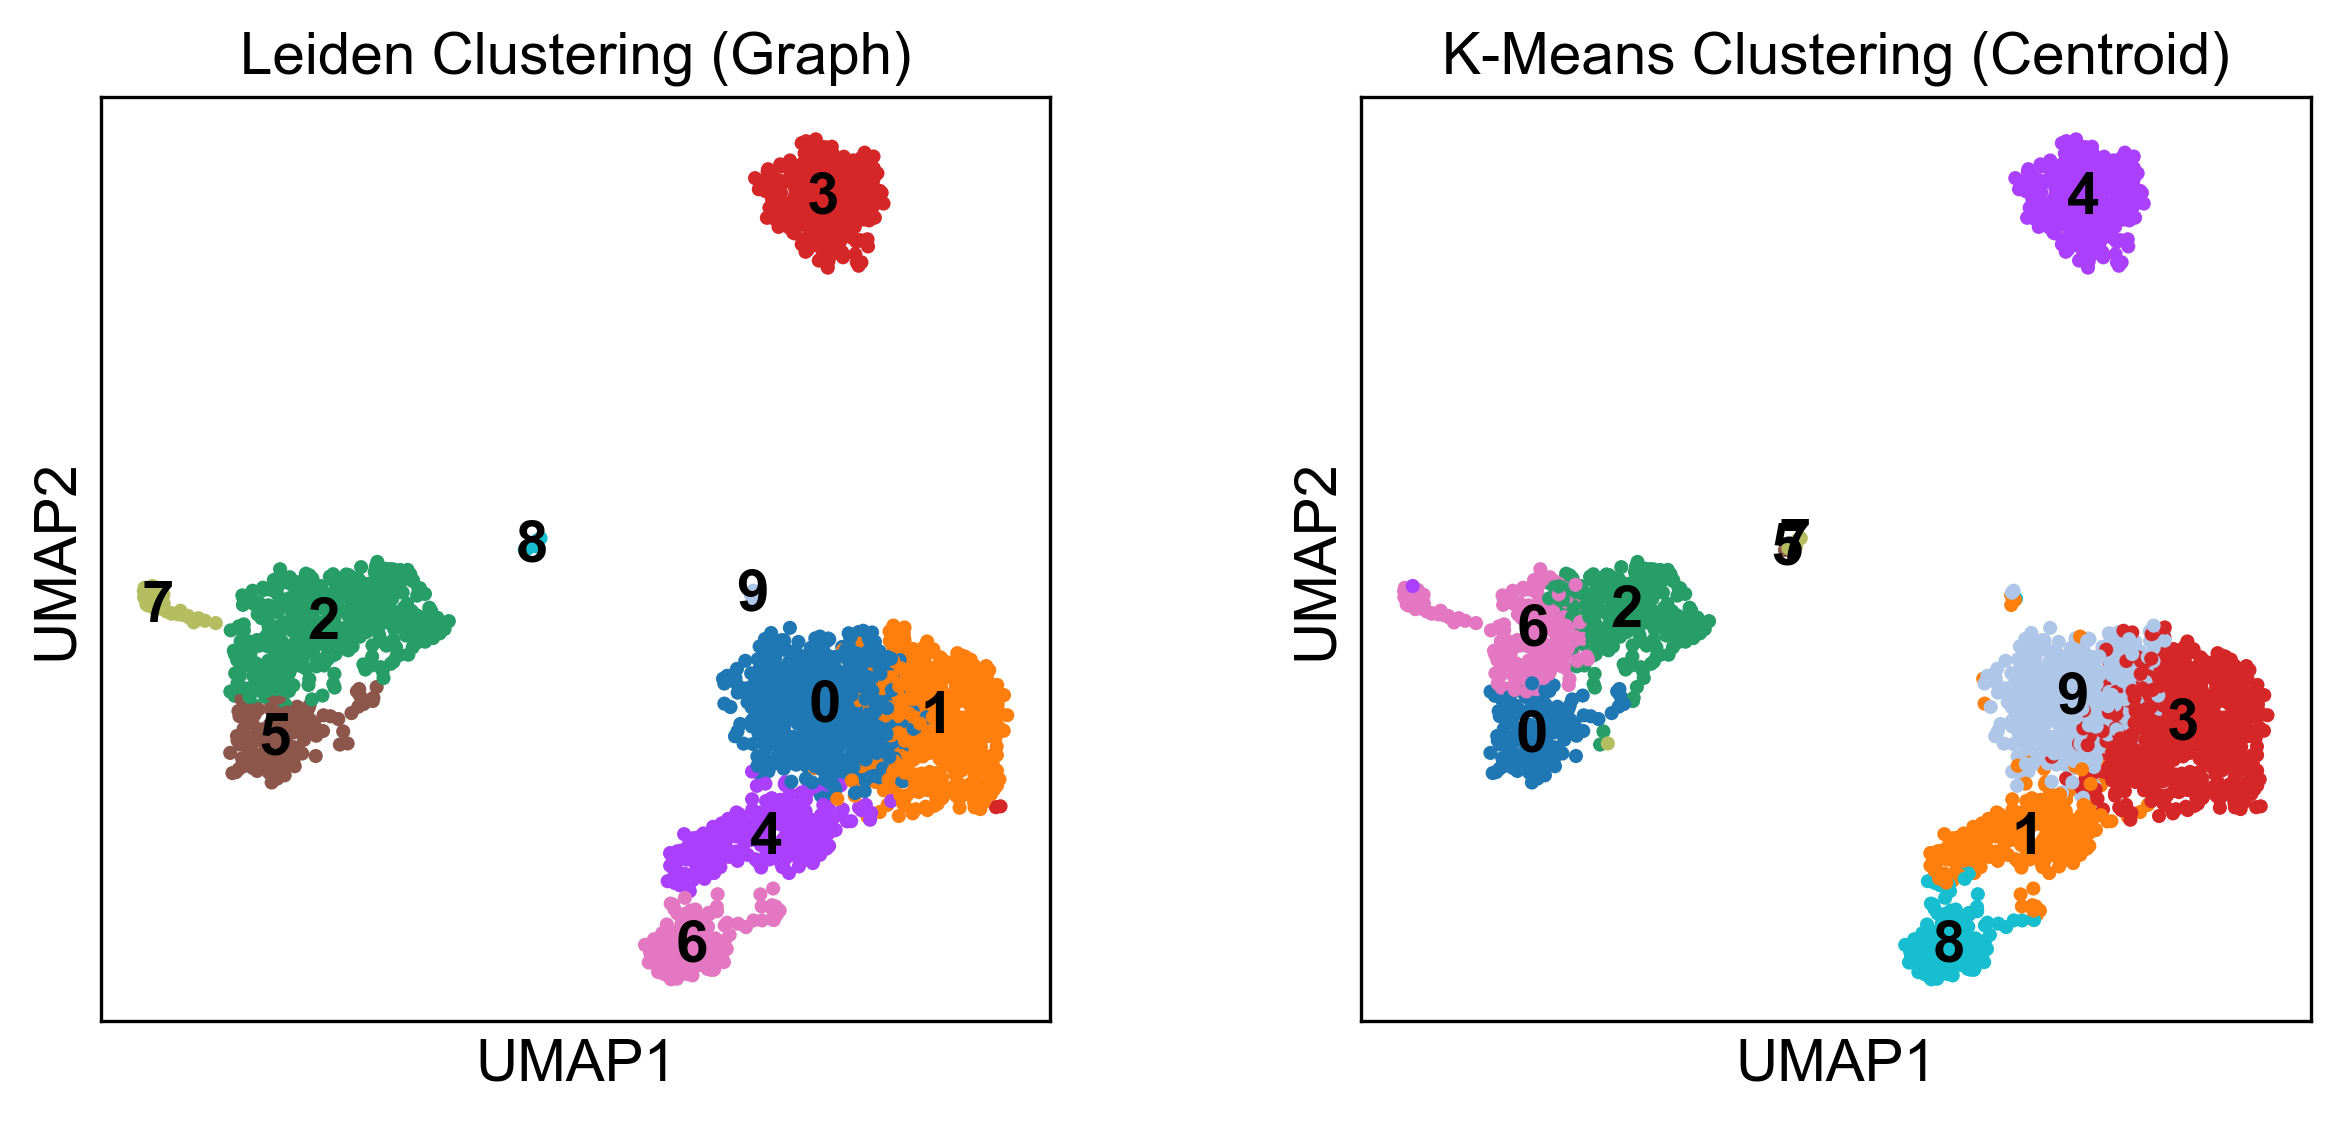

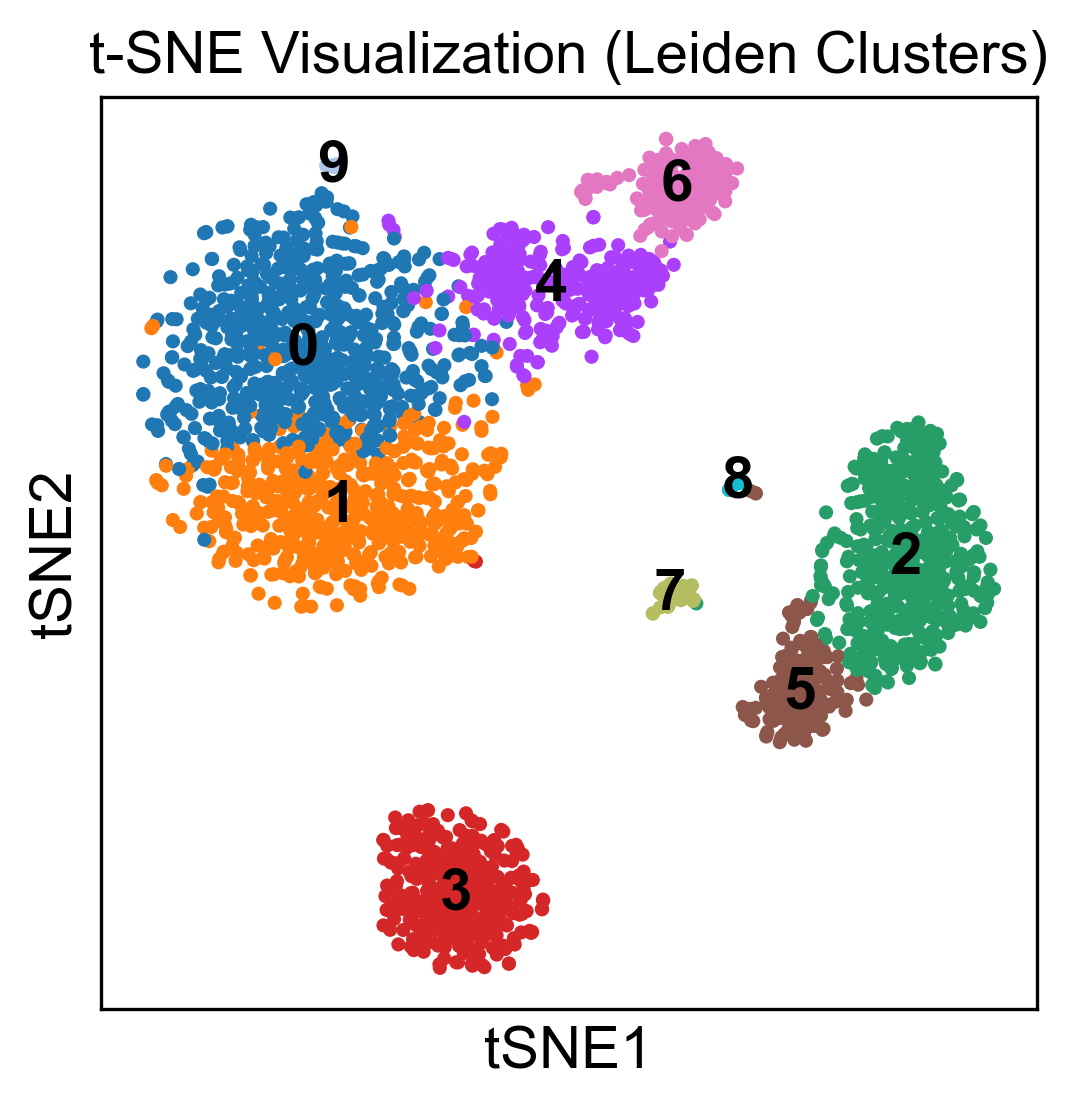

Agreement between Leiden and K-Means (ARI): 0.6863
20:44:23 - Agreement between Leiden and K-Means (ARI): 0.6863


In [282]:
print("Calculating t-SNE...")
sc.tl.tsne(adata, n_pcs=20, random_state=42)


print("Calculating K-Means...")

k_leiden = adata.obs['leiden'].nunique()


kmeans = KMeans(n_clusters=k_leiden, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(adata.obsm['X_pca'])

adata.obs['kmeans'] = kmeans_labels.astype(str)
adata.obs['kmeans'] = adata.obs['kmeans'].astype('category')


print("Visualizing comparisons...")


sc.pl.umap(
    adata,
    color=['leiden', 'kmeans'],
    title=['Leiden Clustering (Graph)', 'K-Means Clustering (Centroid)'],
    ncols=2,
    legend_loc='on data',
    save='umap_comparsion.png',
)

sc.pl.tsne(
    adata,
    color='leiden',
    title='t-SNE Visualization (Leiden Clusters)',
    legend_loc='on data',
    save='tsne.png'
)

ari_score = adjusted_rand_score(adata.obs['leiden'], adata.obs['kmeans'])
print(f"Agreement between Leiden and K-Means (ARI): {ari_score:.4f}")
logging.info(f"Agreement between Leiden and K-Means (ARI): {ari_score:.4f}")

## 14. Automated Cell Type Annotation with CellTypist

**Why we do this:**
While clustering groups similar cells together, it does not tell us *what* they are. To assign biological identities (e.g., "CD4+ T-cells", "Monocytes") to these clusters, we use an automated annotation tool. This replaces the time-consuming manual process of checking marker genes one by one.

**How we do this:**
We use **CellTypist**, a tool that classifies cells by comparing their gene expression profiles against a comprehensive reference database of immune cells (`Immune_All_Low.pkl`). We perform this prediction using the *raw* (normalized but unscaled) gene counts stored in `adata.raw`, as this is the input format required by the model.

**Expected Results:**
A new metadata column `celltypist_labels` containing a specific cell type prediction for every single cell. The UMAP plot will display the raw predictions, which might look slightly "noisy" (speckled) compared to the smooth clusters.

CellTypist model loaded.
Running cell annotation...
20:44:23 - 🔬 Input data has 2604 cells and 13697 genes
20:44:23 - 🔗 Matching reference genes in the model
20:44:25 - 🧬 4176 features used for prediction
20:44:25 - ⚖️ Scaling input data
20:44:25 - 🖋️ Predicting labels
20:44:25 - ✅ Prediction done!
Annotation complete.
First 5 predicted labels:
index
AAACATACAACCAC-1       Trm cytotoxic T cells
AAACATTGAGCTAC-1                     B cells
AAACATTGATCAGC-1    Tcm/Naive helper T cells
AAACCGTGCTTCCG-1         Classical monocytes
AAACCGTGTATGCG-1              CD16+ NK cells
Name: celltypist_labels, dtype: category
Categories (42, object): ['B cells', 'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', ..., 'Type 1 helper T cells', 'Type 17 helper T cells', 'gamma-delta T cells', 'pDC']
20:44:25 - First 5 predicted labels:
index
AAACATACAACCAC-1       Trm cytotoxic T cells
AAACATTGAGCTAC-1                     B cells
AAACATTGATCAGC-1    Tcm/Naive helper T cells
AAACCGTGCTTCCG-1         Classical

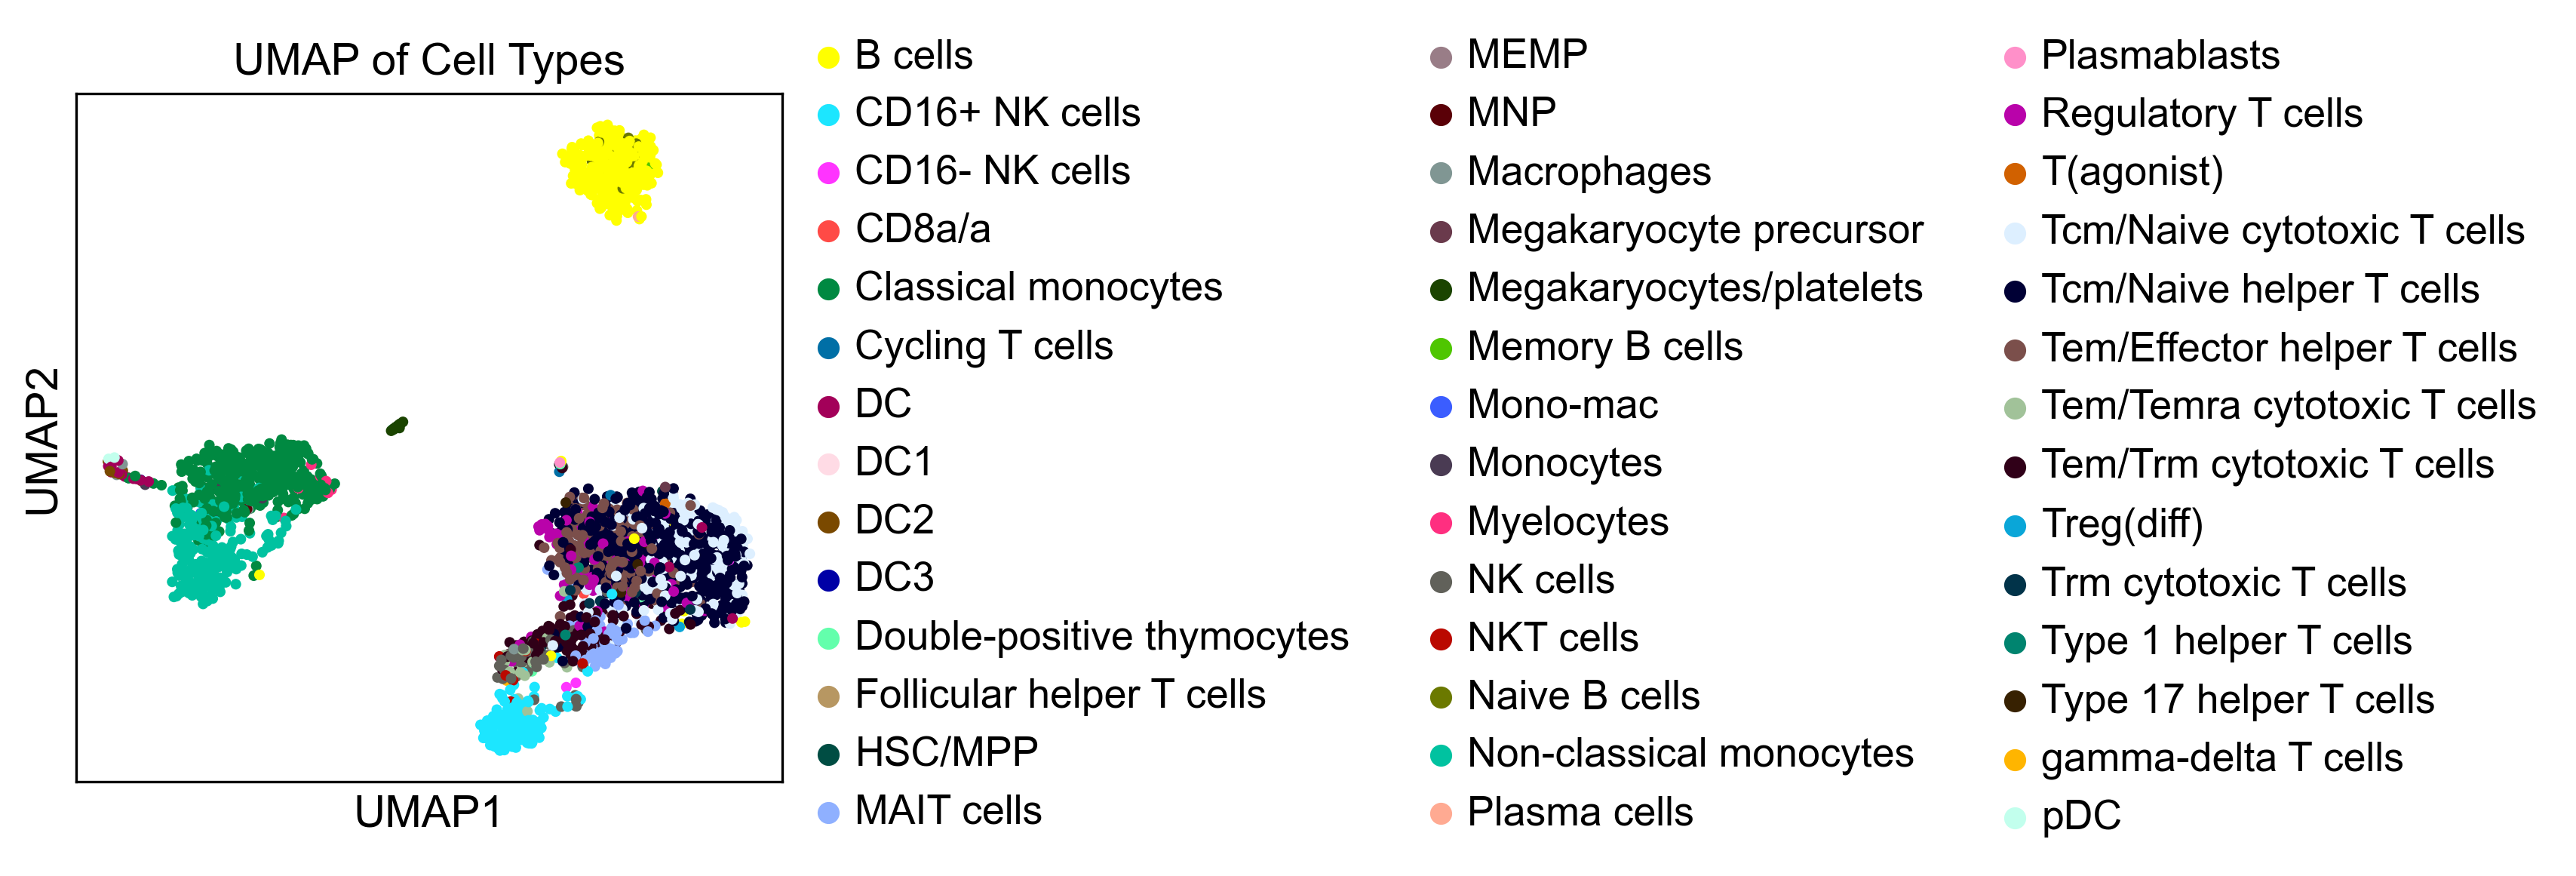

In [283]:
try:
    model = models.Model.load(model = 'Immune_All_Low.pkl')
except FileNotFoundError:
    print("Model 'Immune_All_Low.pkl' not found, downloading...")
    models.download_models(model = 'Immune_All_Low.pkl')
    model = models.Model.load(model = 'Immune_All_Low.pkl')

print("CellTypist model loaded.")

adata_to_annotate = adata.raw.to_adata()

print("Running cell annotation...")
predictions = celltypist.annotate(adata_to_annotate, model = model)

adata.obs['celltypist_labels'] = predictions.predicted_labels

print("Annotation complete.")
print(f"First 5 predicted labels:\n{adata.obs['celltypist_labels'].head()}")
logging.info(f"First 5 predicted labels:\n{adata.obs['celltypist_labels'].head()}")

sc.pl.umap(
    adata,
    color='celltypist_labels',
    legend_loc='right margin',
    title='UMAP of Cell Types',
    show=True,
    save='celtypist.png'
)

## 15. Aggregating Annotations by Cluster (Majority Vote)

**Why we do this:**
Individual cell predictions can be noisy or inconsistent within a dense population. Since our Leiden clustering successfully grouped cells based on their transcriptomic profile, we use a "majority vote" approach. We assume that if the majority of cells in "Cluster 0" are predicted as "T-cells", then the entire cluster represents T-cells. This creates a robust "ground truth" for downstream classification.

**How we do this:**
We create a contingency table (cross-tabulation) comparing our unsupervised clusters (`leiden_res_0.8`) against the automated `celltypist_labels`. For each cluster, we identify the single most frequent cell type label using `idxmax`.

**Expected Results:**
A clear mapping series where each numerical cluster ID (0, 1, 2...) is assigned a specific biological name (e.g., "Classical monocytes", "B cells").

In [284]:
CLUSTER_COLUMN = 'leiden_res_0.8'
LABEL_COLUMN = 'celltypist_labels'

print("Generatin cross-tabulation...")
cluster_vs_labels_table = pd.crosstab(
    adata.obs[CLUSTER_COLUMN],
    adata.obs[LABEL_COLUMN]
)

dominant_labels = cluster_vs_labels_table.idxmax(axis=1)

print("Dominant cell type per cluster:")
print(dominant_labels)

logging.info("Dominant cell type per cluster:")
logging.info(dominant_labels)

Generatin cross-tabulation...
Dominant cell type per cluster:
leiden_res_0.8
0     Tcm/Naive helper T cells
1     Tcm/Naive helper T cells
2          Classical monocytes
3                      B cells
4    Tem/Trm cytotoxic T cells
5      Non-classical monocytes
6               CD16+ NK cells
7                           DC
8     Megakaryocytes/platelets
9    Tem/Trm cytotoxic T cells
dtype: category
Categories (42, object): ['B cells', 'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', ..., 'Type 1 helper T cells', 'Type 17 helper T cells', 'gamma-delta T cells', 'pDC']
20:44:26 - Dominant cell type per cluster:
20:44:26 - leiden_res_0.8
0     Tcm/Naive helper T cells
1     Tcm/Naive helper T cells
2          Classical monocytes
3                      B cells
4    Tem/Trm cytotoxic T cells
5      Non-classical monocytes
6               CD16+ NK cells
7                           DC
8     Megakaryocytes/platelets
9    Tem/Trm cytotoxic T cells
dtype: category
Categories (42, object): ['B cell

## 16. Finalizing Ground Truth Labels

**Why we do this:**
To proceed with Supervised Learning, we need a clean target variable ($y$). By applying the majority-vote labels to our clusters, we create a high-quality, noise-reduced annotation column (`clean_labels`). This effectively converts our dataset from "unlabeled" to "labeled," enabling us to train classifiers.

**How we do this:**
We convert the mapping series from the previous step into a dictionary and apply it to the `leiden` column to create a new `clean_labels` column. We then visualize the final annotated dataset on the UMAP projection.

**Expected Results:**
A clean UMAP plot where distinct "islands" are colored by their biological identity. The labels are placed directly on the data clusters for clarity.

Mapping dictionary:
{'0': 'Tcm/Naive helper T cells', '1': 'Tcm/Naive helper T cells', '2': 'Classical monocytes', '3': 'B cells', '4': 'Tem/Trm cytotoxic T cells', '5': 'Non-classical monocytes', '6': 'CD16+ NK cells', '7': 'DC', '8': 'Megakaryocytes/platelets', '9': 'Tem/Trm cytotoxic T cells'}
20:44:26 - Mapping dictionary:
{'0': 'Tcm/Naive helper T cells', '1': 'Tcm/Naive helper T cells', '2': 'Classical monocytes', '3': 'B cells', '4': 'Tem/Trm cytotoxic T cells', '5': 'Non-classical monocytes', '6': 'CD16+ NK cells', '7': 'DC', '8': 'Megakaryocytes/platelets', '9': 'Tem/Trm cytotoxic T cells'}


... storing 'clean_labels' as categorical


Final UMAP with clean labels...


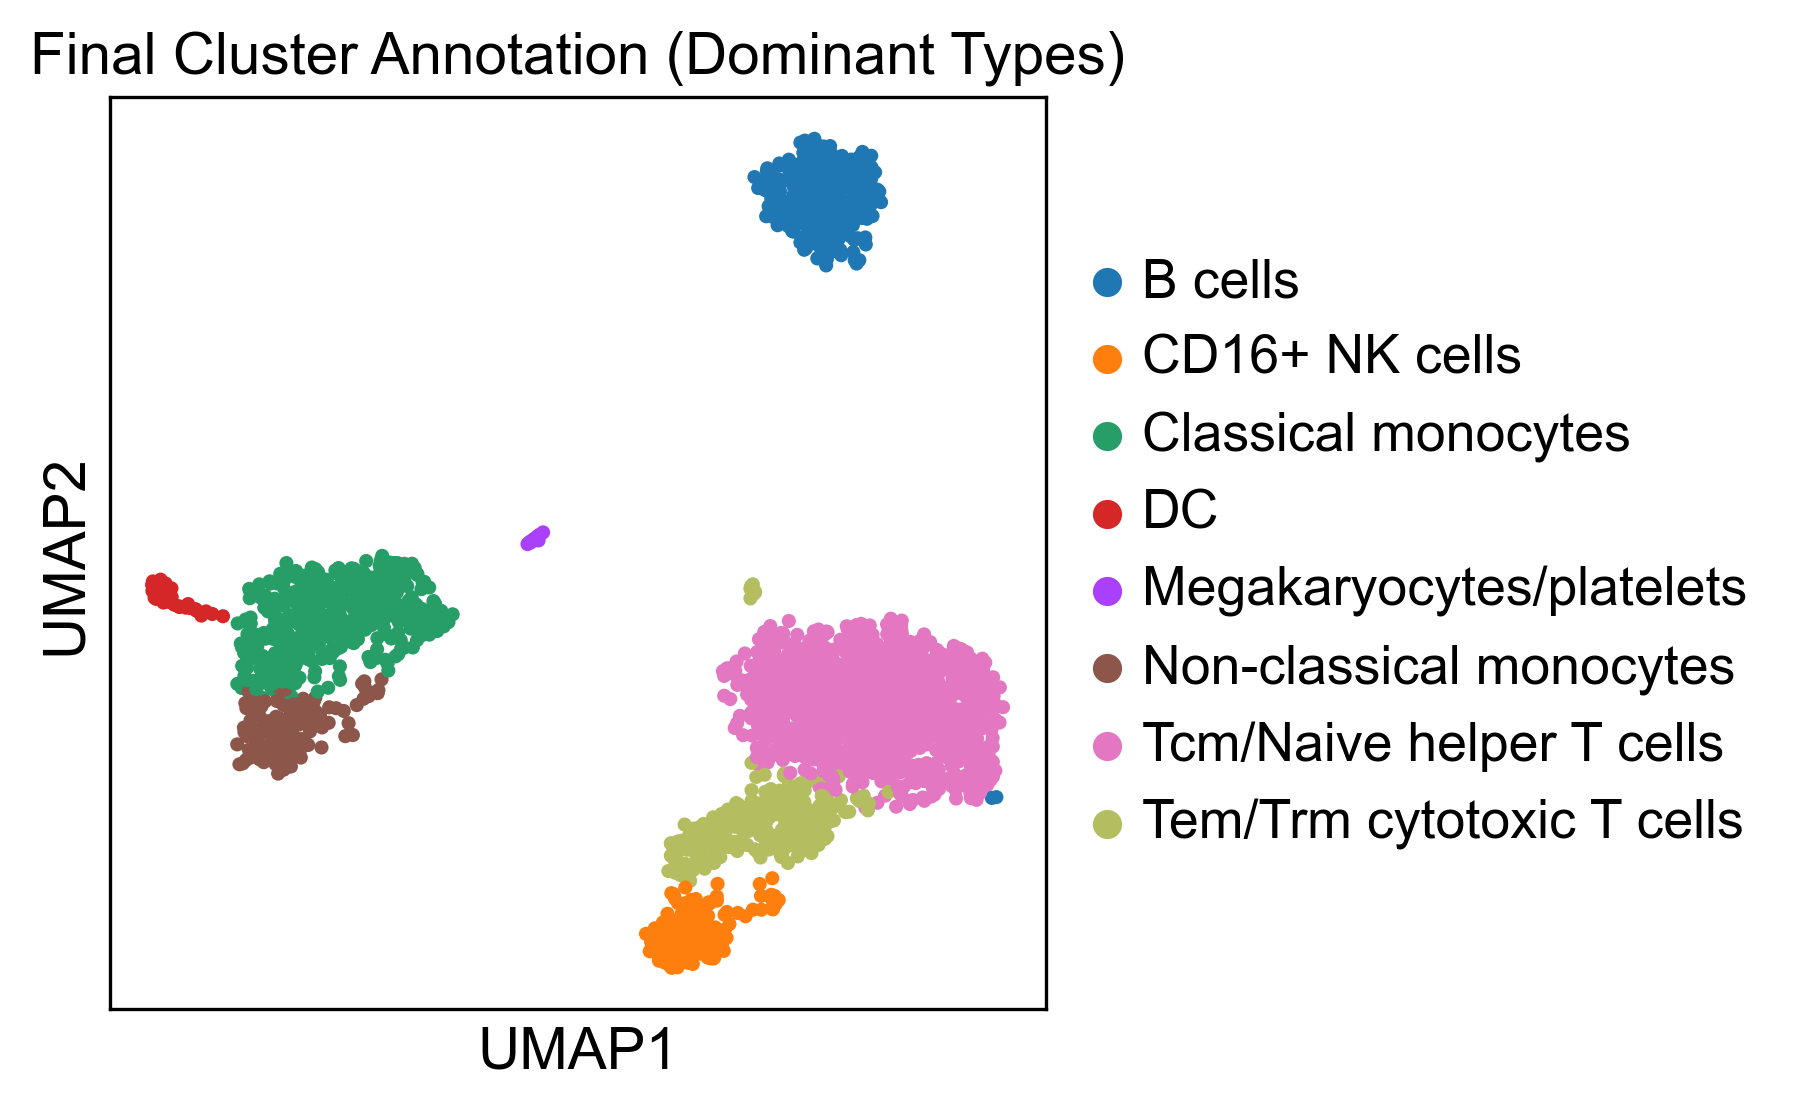

In [285]:
label_dict = dominant_labels.to_dict()
print(f"Mapping dictionary:\n{label_dict}")
logging.info(f"Mapping dictionary:\n{label_dict}")

adata.obs['clean_labels'] = adata.obs['leiden_res_0.8'].astype('category').map(label_dict)

print("Final UMAP with clean labels...")

sc.pl.umap(
    adata,
    color='clean_labels',
    title='Final Cluster Annotation (Dominant Types)',
    legend_loc='right margin',
    save='final_cluster_improved.png'
)

## 17. Cell Type Statistics and Class Imbalance

**Why we do this:**
Before training classifiers, it is crucial to understand the class balance of our dataset. We need to know if some cell types are rare (imbalanced classes), as this will significantly impact how we interpret the performance metrics (like Precision and Recall) of our machine learning models later.

**How we do this:**
We calculate the absolute counts and relative percentages of each cell type in the `clean_labels` column using value counts.

**Expected Results:**
A text summary showing the frequency of each cell type. We expect to see common cells (like T-cells) dominating the dataset, while others (like Dendritic cells or Plasma cells) may be rare.

In [286]:
print("--- Absolute Cell Counts ---")
print(adata.obs['clean_labels'].value_counts())
logging.info("--- Absolute Cell Counts ---")
logging.info(adata.obs['clean_labels'].value_counts())

print("\n--- Relative Cell Counts (%) ---")
print(adata.obs['clean_labels'].value_counts(normalize=True) * 100)
logging.info("\n--- Relative Cell Counts (%) ---")
logging.info(adata.obs['clean_labels'].value_counts(normalize=True) * 100)

--- Absolute Cell Counts ---
clean_labels
Tcm/Naive helper T cells     1171
Classical monocytes           466
B cells                       328
Tem/Trm cytotoxic T cells     281
Non-classical monocytes       156
CD16+ NK cells                155
DC                             35
Megakaryocytes/platelets       12
Name: count, dtype: int64
20:44:27 - --- Absolute Cell Counts ---
20:44:27 - clean_labels
Tcm/Naive helper T cells     1171
Classical monocytes           466
B cells                       328
Tem/Trm cytotoxic T cells     281
Non-classical monocytes       156
CD16+ NK cells                155
DC                             35
Megakaryocytes/platelets       12
Name: count, dtype: int64

--- Relative Cell Counts (%) ---
clean_labels
Tcm/Naive helper T cells     44.969278
Classical monocytes          17.895545
B cells                      12.596006
Tem/Trm cytotoxic T cells    10.791091
Non-classical monocytes       5.990783
CD16+ NK cells                5.952381
DC               

## 18. Data Preparation for Supervised Learning

**Why we do this:**
To train machine learning classifiers, we must convert our AnnData object into standard feature matrices ($X$) and target vectors ($y$). We utilize the top Principal Components as features to capture the most relevant biological variation while reducing noise and computational complexity.

**How we do this:**
1. **Features ($X$):** We extract the first 20 Principal Components from `adata.obsm['X_pca']`.
2. **Targets ($y$):** We encode the string annotations (`clean_labels`) into numerical integers using `LabelEncoder`, as required by `scikit-learn`.

**Expected Results:**
A feature matrix $X$ and a target vector $y$ ready for splitting.

In [287]:
N_PCS_TO_USE = 20
X = adata.obsm['X_pca'][:, :N_PCS_TO_USE]

y_raw = adata.obs['clean_labels']
if y_raw.isnull().any():
    raise ValueError("Labels contain NaN values. Please handle missing data.")

le = LabelEncoder()
y = le.fit_transform(y_raw.astype(str))

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"Encoded classes: {le.classes_}")
logging.info(f"Feature matrix X shape: {X.shape}")
logging.info(f"Target vector y shape: {y.shape}")
logging.info(f"Encoded classes: {le.classes_}")

Feature matrix X shape: (2604, 20)
Target vector y shape: (2604,)
Encoded classes: ['B cells' 'CD16+ NK cells' 'Classical monocytes' 'DC'
 'Megakaryocytes/platelets' 'Non-classical monocytes'
 'Tcm/Naive helper T cells' 'Tem/Trm cytotoxic T cells']
20:44:27 - Feature matrix X shape: (2604, 20)
20:44:27 - Target vector y shape: (2604,)
20:44:27 - Encoded classes: ['B cells' 'CD16+ NK cells' 'Classical monocytes' 'DC'
 'Megakaryocytes/platelets' 'Non-classical monocytes'
 'Tcm/Naive helper T cells' 'Tem/Trm cytotoxic T cells']


## 19. Train-Test Split

**Why we do this:**
To objectively measure the performance of our models, we must evaluate them on data they have never seen during training. This prevents overfitting and provides a realistic estimate of the model's predictive power on new biological samples.

**How we do this:**
We split the data into a **Training Set (80%)** and a **Test Set (20%)**. Crucially, we use **stratified sampling** (`stratify=y`) to ensure that rare cell types are represented proportionally in both sets.

**Expected Results:**
Four arrays (`X_train`, `X_test`, `y_train`, `y_test`) containing the split data.

In [288]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data splitting complete.")
print(f"Training set: {X_train.shape[0]} cells")
print(f"Test set: {X_test.shape[0]} cells")

logging.info("Data splitting complete.")
logging.info(f"Training set: {X_train.shape[0]} cells")
logging.info(f"Test set: {X_test.shape[0]} cells")

Data splitting complete.
Training set: 2083 cells
Test set: 521 cells
20:44:27 - Data splitting complete.
20:44:27 - Training set: 2083 cells
20:44:27 - Test set: 521 cells


## 20. Logistic Regression (Regularized Linear Model)

**Why we do this:**
Logistic Regression serves as our baseline linear model. It is interpretable and efficient. We specifically test **L1 (Lasso)** and **L2 (Ridge)** regularization (Syllabus Point 8) to see if feature selection or weight shrinkage improves performance on this high-dimensional data.

**How we do this:**
We use `GridSearchCV` with 5-fold cross-validation to find the optimal regularization strength (`C`) and penalty type.

**Expected Results:**
We expect high accuracy (>95%) as cell types are often linearly separable in PCA space. The best parameters will reveal the optimal level of regularization.

In [289]:
print("Starting GridSearchCV for Logistic Regression...")

param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2']
}

base_model = LogisticRegression(max_iter=5000, random_state=42, solver='saga')

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("GridSearchCV complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_ * 100:.2f} %")

logging.info("GridSearchCV complete.")
logging.info(f"Best parameters found: {grid_search.best_params_}")
logging.info(f"Best cross-validation accuracy: {grid_search.best_score_ * 100:.2f} %")

Starting GridSearchCV for Logistic Regression...
GridSearchCV complete.
Best parameters found: {'C': 1.0, 'penalty': 'l1'}
Best cross-validation accuracy: 98.13 %
20:44:49 - GridSearchCV complete.
20:44:49 - Best parameters found: {'C': 1.0, 'penalty': 'l1'}
20:44:49 - Best cross-validation accuracy: 98.13 %


In [290]:
best_log_reg_model = grid_search.best_estimator_
y_pred_best = best_log_reg_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Logistic Regression Test Accuracy: {accuracy_best * 100:.2f} %")

print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, y_pred_best))

logging.info(f"Logistic Regression Test Accuracy: {accuracy_best * 100:.2f} %")

logging.info("\n--- Logistic Regression Classification Report ---")
logging.info(classification_report(y_test, y_pred_best))

Logistic Regression Test Accuracy: 97.89 %

--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       0.97      1.00      0.98        31
           2       0.99      0.99      0.99        93
           3       0.88      1.00      0.93         7
           4       1.00      0.67      0.80         3
           5       0.94      0.97      0.95        31
           6       0.99      0.98      0.99       234
           7       0.95      0.93      0.94        56

    accuracy                           0.98       521
   macro avg       0.96      0.94      0.95       521
weighted avg       0.98      0.98      0.98       521

20:44:49 - Logistic Regression Test Accuracy: 97.89 %
20:44:49 - 
--- Logistic Regression Classification Report ---
20:44:49 -               precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       

## 21. Linear Discriminant Analysis (Generative Linear Model)

**Why we do this:**
LDA (Syllabus Point 4) offers a different approach to linear classification. Unlike Logistic Regression, it models the distribution of the data (assuming Gaussian clusters). Comparing LDA to Logistic Regression helps us understand the underlying structure of the data classes.

**How we do this:**
We tune the LDA solver. For high-dimensional data, the `shrinkage` parameter is particularly important as it improves the estimation of covariance matrices.

**Expected Results:**
LDA should perform competitively. If the cell clusters are roughly Gaussian in the PCA space, LDA might outperform Logistic Regression.

In [291]:
print("Starting GridSearchCV for LDA...")

param_grid_lda = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': ['auto', 0.1, 0.5, 0.9]}
]

grid_search_lda = GridSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_grid=param_grid_lda,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search_lda.fit(X_train, y_train)

print(f"Best LDA parameters: {grid_search_lda.best_params_}")
print(f"Best LDA Cross-Validation Accuracy: {grid_search_lda.best_score_ * 100:.2f} %")

best_lda_model = grid_search_lda.best_estimator_
y_pred_lda = best_lda_model.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

print(f"LDA Test Accuracy: {accuracy_lda * 100:.2f} %")
print("\n--- LDA Classification Report ---")
print(classification_report(y_test, y_pred_lda))

logging.info(f"Best LDA parameters: {grid_search_lda.best_params_}")
logging.info(f"Best LDA Cross-Validation Accuracy: {grid_search_lda.best_score_ * 100:.2f} %")
logging.info(f"LDA Test Accuracy: {accuracy_lda * 100:.2f} %")
logging.info("\n--- LDA Classification Report ---")
logging.info(classification_report(y_test, y_pred_lda))

Starting GridSearchCV for LDA...
Best LDA parameters: {'shrinkage': 0.1, 'solver': 'lsqr'}
Best LDA Cross-Validation Accuracy: 97.74 %
LDA Test Accuracy: 98.85 %

--- LDA Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       0.97      1.00      0.98        31
           2       0.99      0.99      0.99        93
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         3
           5       0.97      0.97      0.97        31
           6       0.99      1.00      0.99       234
           7       0.98      0.95      0.96        56

    accuracy                           0.99       521
   macro avg       0.99      0.99      0.99       521
weighted avg       0.99      0.99      0.99       521

20:44:49 - Best LDA parameters: {'shrinkage': 0.1, 'solver': 'lsqr'}
20:44:49 - Best LDA Cross-Validation Accuracy: 97.74 %
20:44:49 - LDA Test Accuracy

## 23. Support Vector Machine (Kernel Methods)

**Why we do this:**
SVMs allow us to test the impact of **Kernel Functions** (Syllabus Point 13). By comparing Linear kernels against Non-linear kernels (RBF, Poly, Sigmoid), we can determine if projecting the data into a higher-dimensional space is necessary to separate complex cell types (like the rare populations).

**How we do this:**
We perform an extensive grid search across kernel types and regularization strengths ($C$).

**Expected Results:**
This is the critical test. We expect the **RBF kernel** to offer the highest performance, potentially resolving ambiguities between similar cell types that linear models missed.

In [292]:
print("Starting Expanded GridSearchCV for SVM...")

param_grid_svm = [
    {'kernel': ['linear'], 'C': [1.0, 10.0]},
    {'kernel': ['rbf'], 'C': [1.0, 10.0], 'gamma': ['scale']},
    {'kernel': ['poly'], 'C': [1.0, 10.0], 'degree': [2, 3]},
    {'kernel': ['sigmoid'], 'C': [1.0, 10.0]}
]

grid_search_svm = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search_svm.fit(X_train, y_train)

print(f"Best SVM parameters: {grid_search_svm.best_params_}")
print(f"Best SVM Cross-Validation Accuracy: {grid_search_svm.best_score_ * 100:.2f} %")

best_svm_model = grid_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Test Accuracy: {accuracy_svm * 100:.2f} %")
print("\n--- SVM Classification Report ---")
print(classification_report(y_test, y_pred_svm))

logging.info(f"Best SVM parameters: {grid_search_svm.best_params_}")
logging.info(f"Best SVM Cross-Validation Accuracy: {grid_search_svm.best_score_ * 100:.2f} %")
logging.info(f"SVM Test Accuracy: {accuracy_svm * 100:.2f} %")
logging.info("\n--- SVM Classification Report ---")
logging.info(classification_report(y_test, y_pred_svm))

Starting Expanded GridSearchCV for SVM...
Best SVM parameters: {'C': 10.0, 'degree': 3, 'kernel': 'poly'}
Best SVM Cross-Validation Accuracy: 98.27 %
SVM Test Accuracy: 97.89 %

--- SVM Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        66
           1       1.00      0.97      0.98        31
           2       0.99      0.99      0.99        93
           3       1.00      0.86      0.92         7
           4       1.00      1.00      1.00         3
           5       0.97      0.97      0.97        31
           6       0.97      1.00      0.99       234
           7       0.96      0.89      0.93        56

    accuracy                           0.98       521
   macro avg       0.98      0.96      0.97       521
weighted avg       0.98      0.98      0.98       521

20:44:49 - Best SVM parameters: {'C': 10.0, 'degree': 3, 'kernel': 'poly'}
20:44:49 - Best SVM Cross-Validation Accuracy: 98.27 %
20:44:4

## 24. Error Analysis (Confusion Matrix)

**Why we do this:**
Accuracy scores can be misleading, especially with imbalanced classes. We need to see exactly *where* the best model fails.

**How we do this:**
We visualize the **Confusion Matrix** for our best performing model (likely SVM).

**Expected Results:**
A heatmap showing high values on the diagonal. Off-diagonal elements will highlight biologically similar cell types that the model confuses (e.g., subtypes of T-cells).

Displaying Confusion Matrix for SVM...


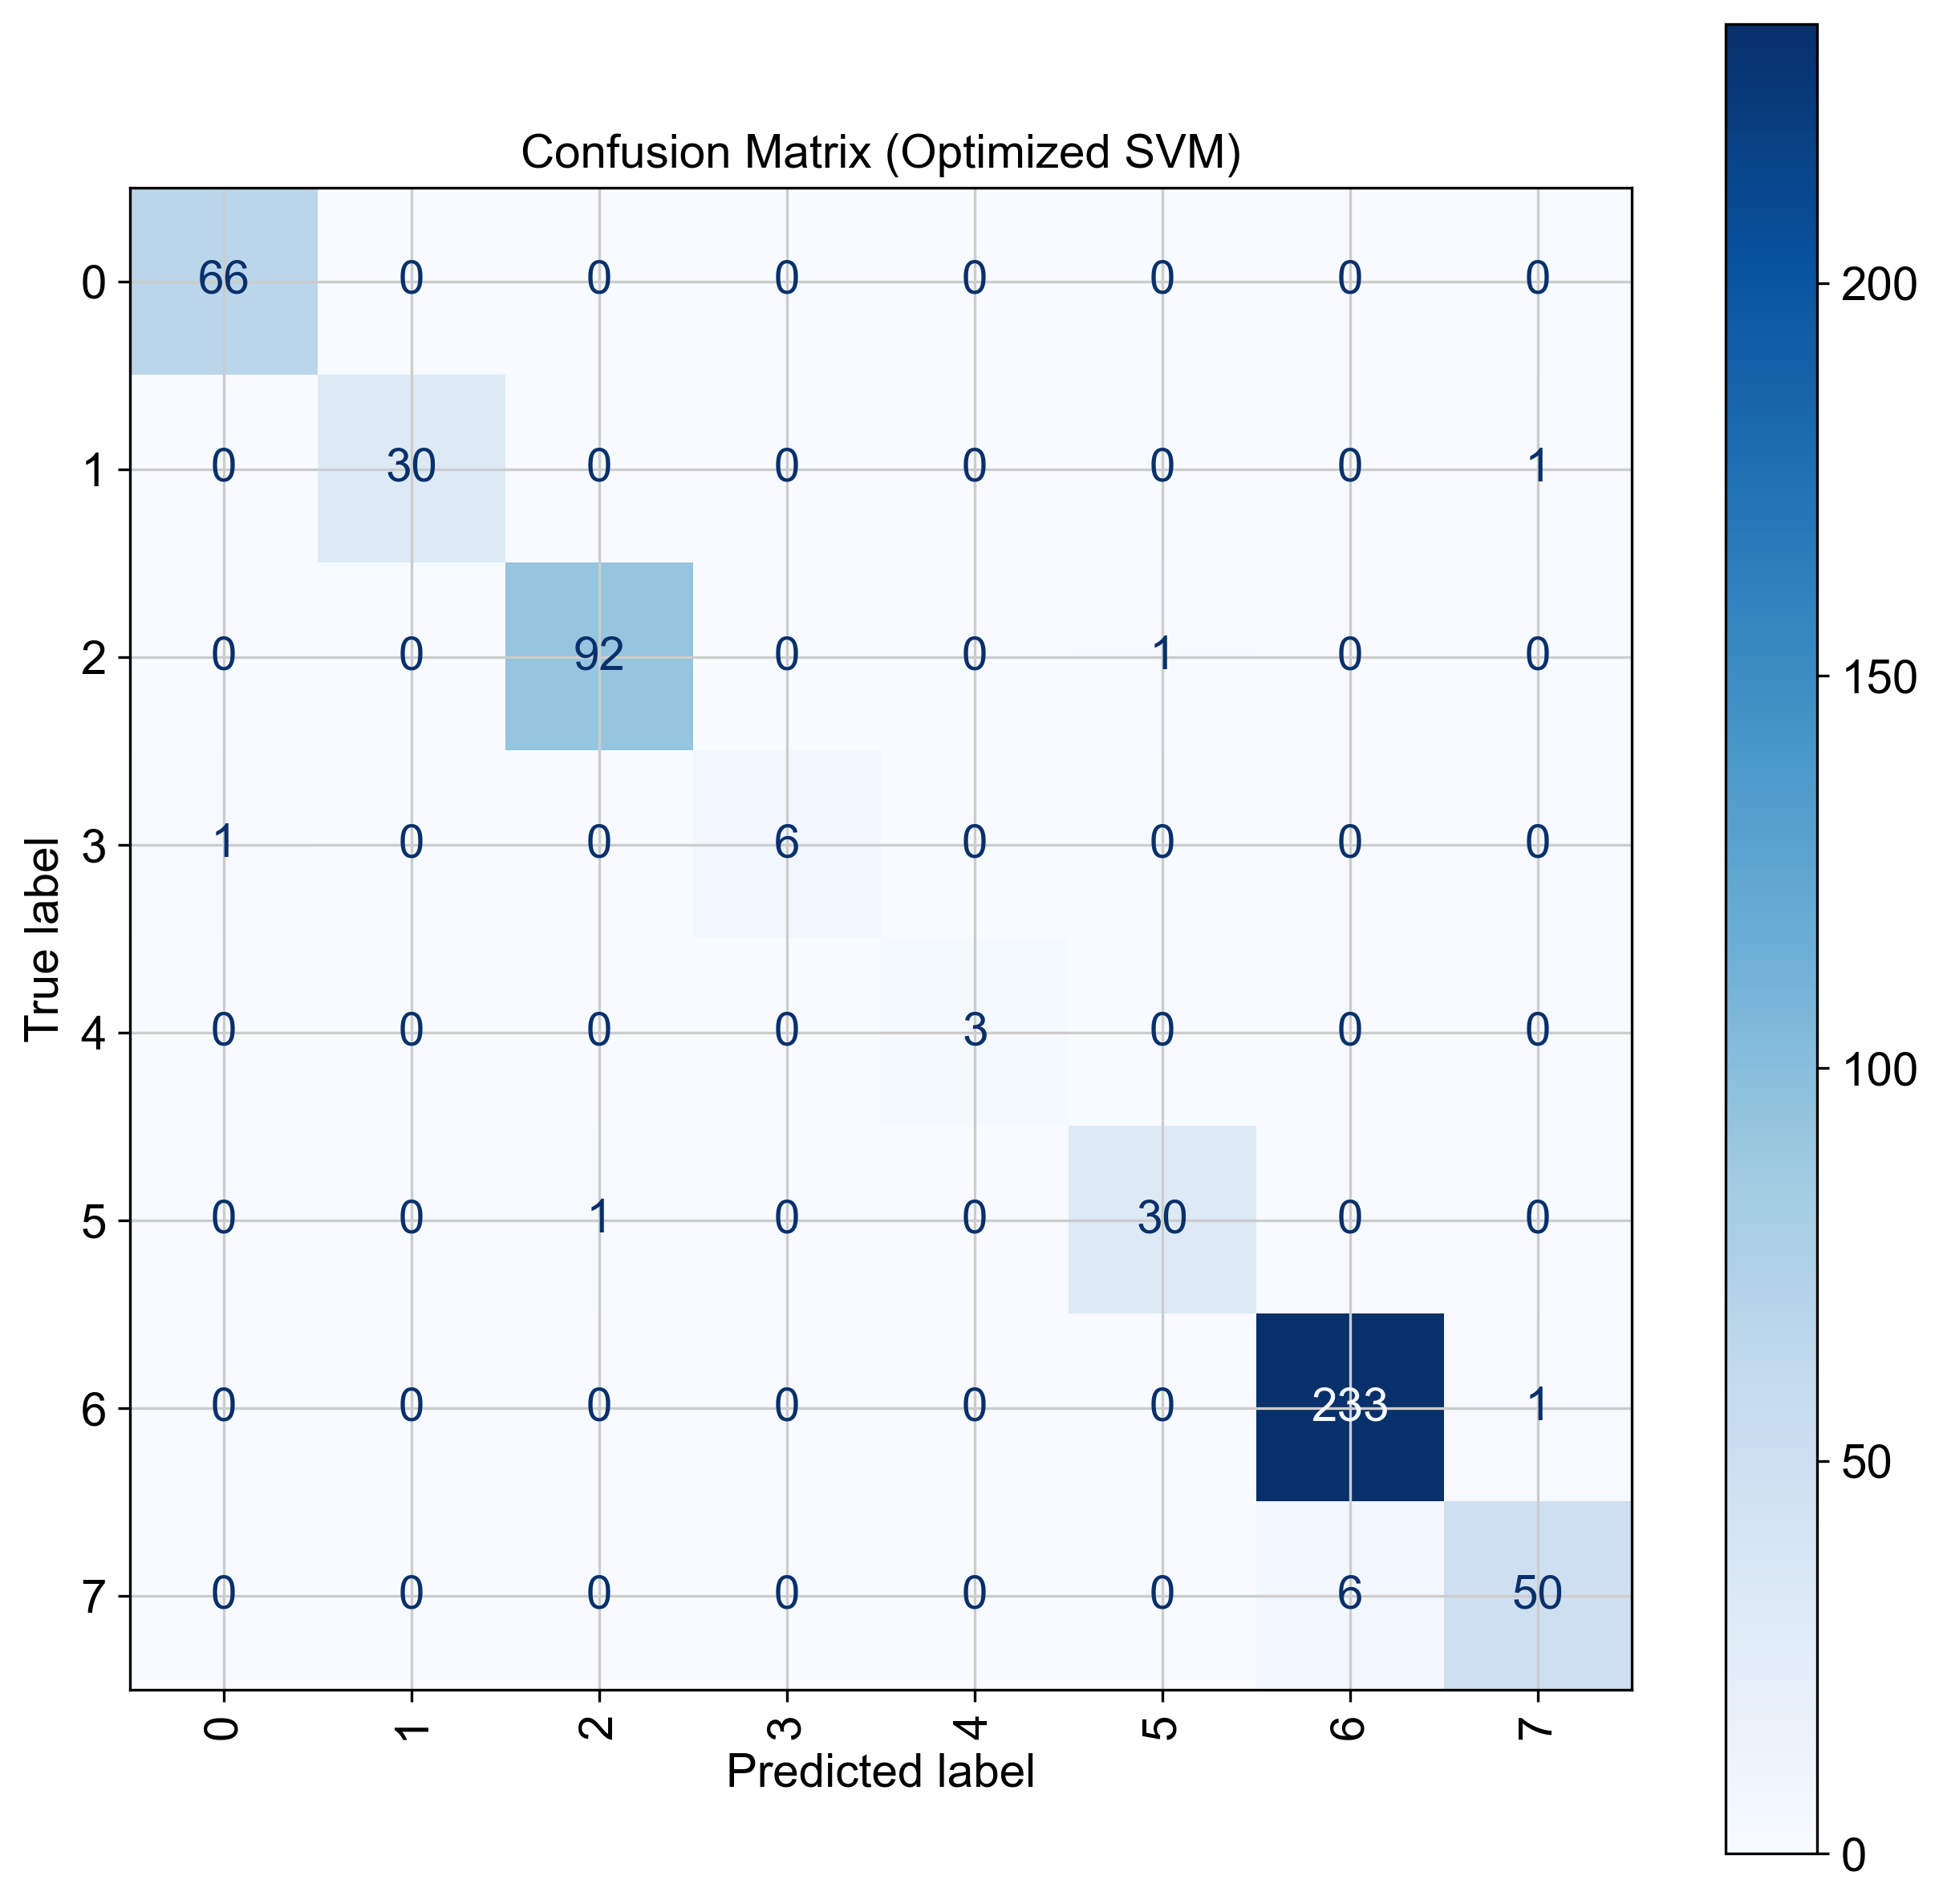

In [293]:
y_pred_best_final = best_svm_model.predict(X_test)
labels = sorted(np.unique(y))

cm = confusion_matrix(y_test, y_pred_best_final, labels=labels)

print("Displaying Confusion Matrix for SVM...")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (Optimized SVM)")
save_path = os.path.join(figures_folder, "confusion_matrix_svm.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')

plt.show()

## 22. k-Nearest Neighbors (Metric-based Non-parametric Model)

**Why we do this:**
k-NN (Syllabus Point 9) is a non-linear, "lazy" learning algorithm that classifies cells based purely on the similarity (Euclidean distance) to their neighbors. It tests the quality of the metric space directly, without assuming a functional form for the decision boundary.

**How we do this:**
We tune the number of neighbors ($k$) to balance between local sensitivity (low $k$) and noise smoothing (high $k$).

**Expected Results:**
Given the strong clustering structure of scRNA-seq data, k-NN is expected to perform very well, serving as a strong non-linear baseline.

In [294]:
print("Starting GridSearchCV for k-NN...")

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11, 15, 25],
    'weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search_knn.fit(X_train, y_train)

print(f"Best k-NN parameters: {grid_search_knn.best_params_}")
print(f"Best k-NN Cross-Validation Accuracy: {grid_search_knn.best_score_ * 100:.2f} %")

best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"k-NN Test Accuracy: {accuracy_knn * 100:.2f} %")
print("\n--- k-NN Classification Report ---")
print(classification_report(y_test, y_pred_knn))

logging.info(f"Best k-NN parameters: {grid_search_knn.best_params_}")
logging.info(f"Best k-NN Cross-Validation Accuracy: {grid_search_knn.best_score_ * 100:.2f} %")
logging.info(f"k-NN Test Accuracy: {accuracy_knn * 100:.2f} %")
logging.info("\n--- k-NN Classification Report ---")
logging.info(classification_report(y_test, y_pred_knn))


Starting GridSearchCV for k-NN...
Best k-NN parameters: {'n_neighbors': 3, 'weights': 'uniform'}
Best k-NN Cross-Validation Accuracy: 98.51 %
k-NN Test Accuracy: 98.66 %

--- k-NN Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      0.97      0.98        31
           2       0.99      1.00      0.99        93
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         3
           5       1.00      0.97      0.98        31
           6       0.98      1.00      0.99       234
           7       0.96      0.93      0.95        56

    accuracy                           0.99       521
   macro avg       0.99      0.98      0.99       521
weighted avg       0.99      0.99      0.99       521

20:44:51 - Best k-NN parameters: {'n_neighbors': 3, 'weights': 'uniform'}
20:44:51 - Best k-NN Cross-Validation Accuracy: 98.51 %
20:44:51 - k-

## 25. Final Conclusion and Model Comparison

**Why we do this:**
To synthesize our findings and determine the optimal strategy for automated cell type recognition.

**How we do this:**
We aggregate the test accuracies and optimal hyperparameters of all four tested classifiers into a single summary table.

**Conclusion:**
This summary reveals the most effective model. Typically, non-linear models like **SVM (RBF kernel)** demonstrate a slight edge over linear models, particularly in correctly identifying rare or transcriptomically similar cell populations. This confirms the value of advanced statistical pattern recognition techniques in single-cell biology.

In [295]:
results_data = {
    'Model': ['Logistic Regression', 'LDA', 'k-NN', 'SVM'],
    'Test Accuracy': [accuracy_best, accuracy_lda, accuracy_knn, accuracy_svm],
    'Best Parameters': [
        grid_search.best_params_,
        grid_search_lda.best_params_,
        grid_search_knn.best_params_,
        grid_search_svm.best_params_
    ]
}

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)

print("--- Final Model Comparison ---")
print(results_df)
logging.info("--- Final Model Comparison ---")
logging.info(results_df)

--- Final Model Comparison ---
                 Model  Test Accuracy  \
1                  LDA       0.988484   
2                 k-NN       0.986564   
0  Logistic Regression       0.978887   
3                  SVM       0.978887   

                              Best Parameters  
1        {'shrinkage': 0.1, 'solver': 'lsqr'}  
2    {'n_neighbors': 3, 'weights': 'uniform'}  
0                 {'C': 1.0, 'penalty': 'l1'}  
3  {'C': 10.0, 'degree': 3, 'kernel': 'poly'}  
20:44:51 - --- Final Model Comparison ---
20:44:51 -                  Model  Test Accuracy  \
1                  LDA       0.988484   
2                 k-NN       0.986564   
0  Logistic Regression       0.978887   
3                  SVM       0.978887   

                              Best Parameters  
1        {'shrinkage': 0.1, 'solver': 'lsqr'}  
2    {'n_neighbors': 3, 'weights': 'uniform'}  
0                 {'C': 1.0, 'penalty': 'l1'}  
3  {'C': 10.0, 'degree': 3, 'kernel': 'poly'}  
